In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import os
import pandas as pd
import sys
import glob
import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.preprocessing import MinMaxScaler
import nbimporter
from transformer_model import WordPiece, Evaluator, BlandAltman2, Objective, BestModelLoader, normalize_data1, normalize_data2, denormalize_data,scatter,find_ids
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score
from torch.nn.utils.rnn import pad_sequence
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders
import optuna
import json
from dataprocess import OutputDataProcessor, DataProcessor, pad_truncate_sequences,DatasetManager
import pickle

In [2]:
import logging
import random
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """

    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")

set_seed(0)

In [7]:
data = np.load(r'F:\junwei\CNN\CNN_keras\data.npy')
output_data = pd.read_excel('F:\junwei\dataset\_MASTER_modified.xlsx',usecols=['Crs', 'R'])
train = pd.read_csv(r'F:\junwei\CNN\CNN_keras\train.csv')
test = pd.read_csv(r'F:\junwei\CNN\CNN_keras\test.csv')
val = pd.read_csv(r'F:\junwei\CNN\CNN_keras\val.csv')
volume = data[:,:,0]
flow = data[:,:,1]
pressure= data[:,:,2]
Crs = output_data['Crs']
R = output_data['R']
Crs = Crs.T
R= R.T
flow = flow.T
pressure = pressure.T
volume = volume.T
num_examples = flow.shape[0]
num_samples = flow.shape[1]

(min_flow, max_flow, flow) = normalize_data2(flow)
(min_volume, max_volume, volume) = normalize_data2(volume)
(min_paw, max_paw, pressure) = normalize_data2(pressure)
(min_resistance, max_resistance, R) = normalize_data2(R)
(min_compliance, max_compliance, Crs) = normalize_data2(Crs)
#Crs = np.array(Crs).reshape(-1, 1)  # Reshape to (442, 1)
#R = np.array(R).reshape(-1, 1)  
output_data = np.stack((Crs,R),axis=1)
output_data = pd.DataFrame(output_data)
output_data = output_data.rename(columns={0: "Crs", 1: "R"})
signals = np.stack([flow, volume, pressure], axis=2)
signals = np.transpose(signals, (1, 0, 2))
indices_train = train['Unnamed: 0'].values
indices_test = test['Unnamed: 0'].values
indices_val = val['Unnamed: 0'].values
train_input = signals[indices_train,:,:]
test_input = signals[indices_test,:,:]
val_input = signals[indices_val,:,:]
train_output = output_data.loc[indices_train]
test_output = output_data.loc[indices_test]
val_output = output_data.loc[indices_val]
dataset_manager = DatasetManager(batch_size=8)
dataset_manager.prepare_data(train_input, test_input, val_input, train_output, test_output, val_output)
train_loader, test_loader, valid_loader = dataset_manager.get_loaders()

In [33]:
np.save(r'F:\junwei\Transformer_without_sym\train.npy',train_input)
np.save(r'F:\junwei\Transformer_without_sym\test.npy',test_input)
np.save(r'F:\junwei\Transformer_without_sym\val.npy',val_input)

np.save(r'F:\junwei\Transformer_without_sym\train_output.npy',train_output)
np.save(r'F:\junwei\Transformer_without_sym\test_output.npy',test_output)
np.save(r'F:\junwei\Transformer_without_sym\val_output.npy',val_output)

In [25]:
pool = nn.AvgPool1d(kernel_size=8)

for inputs, targets in train_loader:
    inputs = inputs.transpose(1, 2)
    inputs = inputs.reshape(inputs.shape[0], -1) 
    inputs = inputs.unsqueeze(1) 
    inputs_pooled = pool(inputs)
    inputs_pooled = inputs_pooled.transpose(1, 2)
print(inputs_pooled.shape)

torch.Size([5, 375, 1])


[I 2023-07-08 20:08:21,868] A new study created in memory with name: no-name-23ce973d-0576-4ac7-9f63-08ae98e7b1f7
transformer_model.ipynb:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "\n",
transformer_model.ipynb:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "        trainer = trainers.WordPieceTrainer(vocab_size=self.vocab_size, special_tokens=[\"[PAD]\", \"[UNK]\"])\n",
[I 2023-07-08 20:09:18,790] Trial 0 finished with value: 0.09771488068832292 and parameters: {'nhead': 1, 'weight_decay': 5.90445906224313e-06, 'num_layers': 5, 'dropout': 0.3138412629850773, 'lr': 0.0011289430969912066, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. B

Early stopping after 49 epochs


[I 2023-07-08 20:11:22,855] Trial 1 finished with value: 0.11595836033423741 and parameters: {'nhead': 1, 'weight_decay': 5.942310966893819e-05, 'num_layers': 8, 'dropout': 0.4495626113225805, 'lr': 3.894151685744457e-05, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 69 epochs


[I 2023-07-08 20:12:12,719] Trial 2 finished with value: 0.10026240266031688 and parameters: {'nhead': 3, 'weight_decay': 0.007602753038253192, 'num_layers': 3, 'dropout': 0.24442573833864573, 'lr': 3.44201170246204e-05, 'num_hidden_layers': 3, 'hidden_dim_0': 32, 'hidden_dim_1': 128, 'hidden_dim_2': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 52 epochs


[I 2023-07-08 20:12:51,175] Trial 3 finished with value: 0.10161428401867549 and parameters: {'nhead': 1, 'weight_decay': 7.259950552058224e-05, 'num_layers': 3, 'dropout': 0.2723457122964825, 'lr': 0.006462116646792093, 'num_hidden_layers': 3, 'hidden_dim_0': 32, 'hidden_dim_1': 64, 'hidden_dim_2': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 54 epochs


[I 2023-07-08 20:13:09,427] Trial 4 finished with value: 0.10016311539544 and parameters: {'nhead': 3, 'weight_decay': 0.0002234290076688088, 'num_layers': 3, 'dropout': 0.24287827747993337, 'lr': 0.00021355850116844936, 'num_hidden_layers': 3, 'hidden_dim_0': 64, 'hidden_dim_1': 32, 'hidden_dim_2': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 19 epochs


[I 2023-07-08 20:13:58,556] Trial 5 finished with value: 0.10066347486442989 and parameters: {'nhead': 1, 'weight_decay': 0.005037035757119637, 'num_layers': 5, 'dropout': 0.21003981303236696, 'lr': 0.00812264702884877, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 43 epochs


[I 2023-07-08 20:14:46,383] Trial 6 finished with value: 0.09780231325162782 and parameters: {'nhead': 1, 'weight_decay': 3.5464798758846817e-06, 'num_layers': 4, 'dropout': 0.4867323059901986, 'lr': 0.0023875338076975896, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 52 epochs


[I 2023-07-08 20:15:00,559] Trial 7 finished with value: 0.10147441261344486 and parameters: {'nhead': 1, 'weight_decay': 0.00015499430389840288, 'num_layers': 3, 'dropout': 0.19194126313199697, 'lr': 0.0007081162871330745, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 20 epochs


[I 2023-07-08 20:15:35,902] Trial 8 finished with value: 0.09953344696097904 and parameters: {'nhead': 1, 'weight_decay': 0.0017806386657494172, 'num_layers': 6, 'dropout': 0.42061446398809765, 'lr': 0.001056362602292527, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 26 epochs


[I 2023-07-08 20:15:52,101] Trial 9 finished with value: 0.10178848852713902 and parameters: {'nhead': 1, 'weight_decay': 0.00011714490169043265, 'num_layers': 1, 'dropout': 0.23833626547174613, 'lr': 1.1869922691678438e-05, 'num_hidden_layers': 3, 'hidden_dim_0': 64, 'hidden_dim_1': 128, 'hidden_dim_2': 32}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 39 epochs


[I 2023-07-08 20:17:01,175] Trial 10 finished with value: 0.10233912451399697 and parameters: {'nhead': 3, 'weight_decay': 1.910259428828872e-06, 'num_layers': 7, 'dropout': 0.012953824311634554, 'lr': 0.00031014848503662604, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 32 epochs


[I 2023-07-08 20:17:23,895] Trial 11 finished with value: 0.09857359280188878 and parameters: {'nhead': 1, 'weight_decay': 2.075831903848338e-06, 'num_layers': 5, 'dropout': 0.4973820365519499, 'lr': 0.002157183137505314, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 20 epochs


[I 2023-07-08 20:17:49,754] Trial 12 finished with value: 0.12485248429907693 and parameters: {'nhead': 1, 'weight_decay': 7.589012314342992e-06, 'num_layers': 4, 'dropout': 0.37107019245855366, 'lr': 0.002705020609623884, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 28 epochs


[I 2023-07-08 20:18:03,869] Trial 13 finished with value: 0.10113182663917542 and parameters: {'nhead': 1, 'weight_decay': 6.22265727417162e-06, 'num_layers': 1, 'dropout': 0.3502281647701295, 'lr': 0.000872663029140192, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 0 with value: 0.09771488068832292.


Early stopping after 37 epochs


[I 2023-07-08 20:19:13,974] Trial 14 finished with value: 0.09706961115201314 and parameters: {'nhead': 3, 'weight_decay': 1.1717958569473017e-05, 'num_layers': 6, 'dropout': 0.49173453336722983, 'lr': 0.003255518423876431, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 14 with value: 0.09706961115201314.


Early stopping after 38 epochs


[I 2023-07-08 20:20:06,035] Trial 15 finished with value: 0.10841410193178388 and parameters: {'nhead': 3, 'weight_decay': 1.6671095550316113e-05, 'num_layers': 6, 'dropout': 0.3837861949342094, 'lr': 0.009500624363716521, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 14 with value: 0.09706961115201314.


Early stopping after 28 epochs


[I 2023-07-08 20:20:55,442] Trial 16 finished with value: 0.09664730727672577 and parameters: {'nhead': 3, 'weight_decay': 1.1722407960083248e-06, 'num_layers': 7, 'dropout': 0.3308981030188438, 'lr': 0.0036548037577516647, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 16 with value: 0.09664730727672577.


Early stopping after 23 epochs


[I 2023-07-08 20:21:54,279] Trial 17 finished with value: 0.09608590023385154 and parameters: {'nhead': 3, 'weight_decay': 1.4261980210535246e-06, 'num_layers': 8, 'dropout': 0.42796547243031535, 'lr': 0.005034267437018946, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 24 epochs


[I 2023-07-08 20:23:15,459] Trial 18 finished with value: 0.09894278479946984 and parameters: {'nhead': 3, 'weight_decay': 1.5615034271500223e-06, 'num_layers': 8, 'dropout': 0.40451406055376454, 'lr': 0.00478066972069124, 'num_hidden_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 33 epochs


[I 2023-07-08 20:24:02,710] Trial 19 finished with value: 0.09998516407277849 and parameters: {'nhead': 3, 'weight_decay': 1.030905823037023e-06, 'num_layers': 7, 'dropout': 0.3298576003446022, 'lr': 0.009486173042891465, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 22 epochs


[I 2023-07-08 20:24:58,798] Trial 20 finished with value: 0.10097286187940174 and parameters: {'nhead': 3, 'weight_decay': 2.1650325113570862e-05, 'num_layers': 7, 'dropout': 0.43670071373005587, 'lr': 0.004872390235416966, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 26 epochs


[I 2023-07-08 20:26:44,075] Trial 21 finished with value: 0.10025364408890407 and parameters: {'nhead': 3, 'weight_decay': 1.173515816056392e-06, 'num_layers': 8, 'dropout': 0.45572829614774557, 'lr': 0.0036085543300202394, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 43 epochs


[I 2023-07-08 20:27:17,366] Trial 22 finished with value: 0.0980440725882848 and parameters: {'nhead': 3, 'weight_decay': 2.4636285348052856e-06, 'num_layers': 6, 'dropout': 0.49998815876432706, 'lr': 0.001824372520863888, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 18 epochs


[I 2023-07-08 20:28:48,254] Trial 23 finished with value: 0.10446748965316349 and parameters: {'nhead': 3, 'weight_decay': 4.26612401925048e-06, 'num_layers': 7, 'dropout': 0.41101917009511174, 'lr': 0.004522864352859973, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 42 epochs


[I 2023-07-08 20:30:06,890] Trial 24 finished with value: 0.09907436122496922 and parameters: {'nhead': 3, 'weight_decay': 1.1663349373608147e-05, 'num_layers': 8, 'dropout': 0.4575967206545997, 'lr': 0.0035375048267191115, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 32 epochs


[I 2023-07-08 20:30:40,239] Trial 25 finished with value: 0.0979672877324952 and parameters: {'nhead': 3, 'weight_decay': 1.0225984289897808e-06, 'num_layers': 6, 'dropout': 0.3850942489941474, 'lr': 0.0015450382712577794, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 18 epochs


[I 2023-07-08 20:31:19,023] Trial 26 finished with value: 0.09709626105096605 and parameters: {'nhead': 3, 'weight_decay': 3.2447391609817864e-06, 'num_layers': 7, 'dropout': 0.42487224715900673, 'lr': 0.006000987592548574, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 18 epochs


[I 2023-07-08 20:33:04,769] Trial 27 finished with value: 0.10158947441313002 and parameters: {'nhead': 3, 'weight_decay': 3.0279604064518593e-06, 'num_layers': 8, 'dropout': 0.47129804570261746, 'lr': 0.003311270997710907, 'num_hidden_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 32, 'hidden_dim_2': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 43 epochs


[I 2023-07-08 20:33:43,768] Trial 28 finished with value: 0.10256764623853895 and parameters: {'nhead': 3, 'weight_decay': 1.2002135650498907e-05, 'num_layers': 6, 'dropout': 0.3572345253386414, 'lr': 0.0006101244741594441, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 21 epochs


[I 2023-07-08 20:34:31,023] Trial 29 finished with value: 0.10654693924718434 and parameters: {'nhead': 3, 'weight_decay': 5.100316105643326e-06, 'num_layers': 7, 'dropout': 0.3010934414449636, 'lr': 0.001473811134624031, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 22 epochs


[I 2023-07-08 20:35:25,372] Trial 30 finished with value: 0.11547917707098855 and parameters: {'nhead': 3, 'weight_decay': 1.942103830648003e-06, 'num_layers': 5, 'dropout': 0.46586728406314676, 'lr': 0.0025246725705356525, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 35 epochs


[I 2023-07-08 20:37:23,399] Trial 31 finished with value: 0.1028581667277548 and parameters: {'nhead': 3, 'weight_decay': 3.7462325479305693e-06, 'num_layers': 7, 'dropout': 0.4365028340329284, 'lr': 0.00641020631807544, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 55 epochs


[I 2023-07-08 20:39:06,911] Trial 32 finished with value: 0.10536297659079234 and parameters: {'nhead': 3, 'weight_decay': 2.49080398631949e-06, 'num_layers': 8, 'dropout': 0.41334413150015303, 'lr': 0.005752202514472401, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 42 epochs


[I 2023-07-08 20:39:56,638] Trial 33 finished with value: 0.09855854511260986 and parameters: {'nhead': 3, 'weight_decay': 6.671470588915131e-06, 'num_layers': 7, 'dropout': 0.4327073117761365, 'lr': 0.009820300031823721, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 23 epochs


[I 2023-07-08 20:41:05,283] Trial 34 finished with value: 0.10187709993786281 and parameters: {'nhead': 3, 'weight_decay': 1.4590742111841489e-06, 'num_layers': 8, 'dropout': 0.4720057533728938, 'lr': 0.003878030606922497, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 28 epochs


[I 2023-07-08 20:41:44,344] Trial 35 finished with value: 0.10887384414672852 and parameters: {'nhead': 3, 'weight_decay': 3.5990671387230336e-05, 'num_layers': 6, 'dropout': 0.3950549467445208, 'lr': 0.0067840507164959405, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 21 epochs


[I 2023-07-08 20:42:46,726] Trial 36 finished with value: 0.10087111923429701 and parameters: {'nhead': 3, 'weight_decay': 3.5107379431865584e-06, 'num_layers': 7, 'dropout': 0.4451300129706523, 'lr': 0.0013913414572471364, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 29 epochs


[I 2023-07-08 20:43:16,342] Trial 37 finished with value: 0.10248793330457476 and parameters: {'nhead': 3, 'weight_decay': 9.410618947941406e-06, 'num_layers': 5, 'dropout': 0.3426848333605984, 'lr': 0.005760556906974526, 'num_hidden_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 32, 'hidden_dim_2': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 19 epochs


[I 2023-07-08 20:44:11,752] Trial 38 finished with value: 0.09950424772169855 and parameters: {'nhead': 3, 'weight_decay': 4.500023461538214e-06, 'num_layers': 6, 'dropout': 0.48045851601143424, 'lr': 0.0028396103640048543, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 30 epochs


[I 2023-07-08 20:44:53,619] Trial 39 finished with value: 0.10429895255300733 and parameters: {'nhead': 3, 'weight_decay': 1.4821956909647064e-06, 'num_layers': 8, 'dropout': 0.3682287692064603, 'lr': 0.002058333980149122, 'num_hidden_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'hidden_dim_2': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 17 epochs


[I 2023-07-08 20:45:58,101] Trial 40 finished with value: 0.09959392911858028 and parameters: {'nhead': 3, 'weight_decay': 2.538627813273481e-06, 'num_layers': 7, 'dropout': 0.41955793439223305, 'lr': 0.007510152205694548, 'num_hidden_layers': 1, 'hidden_dim_0': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 30 epochs


[I 2023-07-08 20:46:24,784] Trial 41 finished with value: 0.1024181851082378 and parameters: {'nhead': 1, 'weight_decay': 6.17802117299501e-06, 'num_layers': 4, 'dropout': 0.32102988540103455, 'lr': 0.00415041444707722, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 29 epochs


[I 2023-07-08 20:47:29,494] Trial 42 finished with value: 0.09804737609293726 and parameters: {'nhead': 1, 'weight_decay': 3.3711541768627033e-06, 'num_layers': 5, 'dropout': 0.29851164767821203, 'lr': 0.0011527270546184863, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 57 epochs


[I 2023-07-08 20:47:45,626] Trial 43 finished with value: 0.10298273629612392 and parameters: {'nhead': 1, 'weight_decay': 1.7726591942083629e-06, 'num_layers': 2, 'dropout': 0.39098574647336204, 'lr': 0.002133344312981846, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 32 epochs


[I 2023-07-08 20:48:08,436] Trial 44 finished with value: 0.09883084396521251 and parameters: {'nhead': 1, 'weight_decay': 9.155908624428069e-06, 'num_layers': 5, 'dropout': 0.27336572639671836, 'lr': 0.0029010783010427654, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 20 epochs


[I 2023-07-08 20:48:34,246] Trial 45 finished with value: 0.10045657058556874 and parameters: {'nhead': 1, 'weight_decay': 5.2438604787759625e-06, 'num_layers': 6, 'dropout': 0.368163722498302, 'lr': 0.006174861129993167, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 19 epochs


[I 2023-07-08 20:49:14,745] Trial 46 finished with value: 0.09739665190378825 and parameters: {'nhead': 1, 'weight_decay': 1.9349297169022876e-05, 'num_layers': 4, 'dropout': 0.4930032190921708, 'lr': 0.0006880778255204007, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 44 epochs


[I 2023-07-08 20:49:27,461] Trial 47 finished with value: 0.09853773357139693 and parameters: {'nhead': 1, 'weight_decay': 2.4593396617777168e-05, 'num_layers': 3, 'dropout': 0.49998368825729606, 'lr': 0.00045171587129878534, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 18 epochs


[I 2023-07-08 20:50:44,496] Trial 48 finished with value: 0.10231344981325997 and parameters: {'nhead': 3, 'weight_decay': 4.767679842659523e-05, 'num_layers': 4, 'dropout': 0.47844380920131, 'lr': 0.00013855664412947054, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 61 epochs


[I 2023-07-08 20:50:59,322] Trial 49 finished with value: 0.13630617989434135 and parameters: {'nhead': 1, 'weight_decay': 1.3773477185239443e-05, 'num_layers': 4, 'dropout': 0.4527937944929635, 'lr': 0.0009977316976680353, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 16 epochs


[I 2023-07-08 20:51:17,347] Trial 50 finished with value: 0.10106438646713893 and parameters: {'nhead': 3, 'weight_decay': 7.143035677546899e-05, 'num_layers': 2, 'dropout': 0.43836251453887826, 'lr': 0.007721335483960492, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 27 epochs


[I 2023-07-08 20:51:36,784] Trial 51 finished with value: 0.10166569178303082 and parameters: {'nhead': 1, 'weight_decay': 7.795828060699249e-06, 'num_layers': 5, 'dropout': 0.4188176540952943, 'lr': 0.002318309428598151, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 17 epochs


[I 2023-07-08 20:51:55,287] Trial 52 finished with value: 0.10012446923388375 and parameters: {'nhead': 1, 'weight_decay': 2.084045140391851e-06, 'num_layers': 4, 'dropout': 0.48442398052316027, 'lr': 0.004629819244656682, 'num_hidden_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 32, 'hidden_dim_2': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 20 epochs


[I 2023-07-08 20:52:31,847] Trial 53 finished with value: 0.10081369595395194 and parameters: {'nhead': 1, 'weight_decay': 1.5182327172446907e-05, 'num_layers': 6, 'dropout': 0.45980017513785576, 'lr': 0.0007739620309211779, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 27 epochs


[I 2023-07-08 20:53:01,843] Trial 54 finished with value: 0.09954401933484608 and parameters: {'nhead': 1, 'weight_decay': 1.3391138646042772e-06, 'num_layers': 7, 'dropout': 0.49968017256984676, 'lr': 0.0018189538615847323, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 19 epochs


[I 2023-07-08 20:53:28,725] Trial 55 finished with value: 0.10075067397620943 and parameters: {'nhead': 1, 'weight_decay': 2.9031978894844045e-06, 'num_layers': 3, 'dropout': 0.3981504846039663, 'lr': 0.0029952799219705424, 'num_hidden_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 38 epochs


[I 2023-07-08 20:54:52,479] Trial 56 finished with value: 0.10904509822527568 and parameters: {'nhead': 3, 'weight_decay': 5.3899296513484236e-06, 'num_layers': 8, 'dropout': 0.3789808479794727, 'lr': 0.0011968861180433198, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 34 epochs


[I 2023-07-08 20:56:11,976] Trial 57 finished with value: 0.09940371082888709 and parameters: {'nhead': 3, 'weight_decay': 1.0091192130854888e-06, 'num_layers': 7, 'dropout': 0.4250978871214291, 'lr': 0.0036173456266323087, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 37 epochs


[I 2023-07-08 20:57:08,982] Trial 58 finished with value: 0.0963856362634235 and parameters: {'nhead': 1, 'weight_decay': 1.9583227762051697e-05, 'num_layers': 6, 'dropout': 0.4562640747640727, 'lr': 0.00474608116726175, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 42 epochs


[I 2023-07-08 20:58:14,389] Trial 59 finished with value: 0.09980837669637468 and parameters: {'nhead': 1, 'weight_decay': 1.928919508850686e-05, 'num_layers': 6, 'dropout': 0.45828790609835246, 'lr': 0.004945276058334896, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 48 epochs


[I 2023-07-08 20:59:53,282] Trial 60 finished with value: 0.10102496213383144 and parameters: {'nhead': 3, 'weight_decay': 2.5835438536897536e-05, 'num_layers': 7, 'dropout': 0.44334109415717154, 'lr': 0.009937015269569634, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 46 epochs


[I 2023-07-08 21:00:26,409] Trial 61 finished with value: 0.0970473297768169 and parameters: {'nhead': 1, 'weight_decay': 9.44647758415774e-06, 'num_layers': 5, 'dropout': 0.4870311029928333, 'lr': 0.005162254529442933, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 29 epochs


[I 2023-07-08 21:01:10,212] Trial 62 finished with value: 0.09950333999262916 and parameters: {'nhead': 1, 'weight_decay': 1.1362419046771521e-05, 'num_layers': 5, 'dropout': 0.48521248808449396, 'lr': 0.005251949941321215, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 38 epochs


[I 2023-07-08 21:01:51,070] Trial 63 finished with value: 0.09789920267131594 and parameters: {'nhead': 1, 'weight_decay': 9.25578210217626e-06, 'num_layers': 6, 'dropout': 0.47041402985690417, 'lr': 0.007993266667712228, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 30 epochs


[I 2023-07-08 21:02:16,907] Trial 64 finished with value: 0.09707762963242 and parameters: {'nhead': 1, 'weight_decay': 3.1504721589465265e-05, 'num_layers': 4, 'dropout': 0.48626719290988796, 'lr': 0.003776413797445857, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 28 epochs


[I 2023-07-08 21:02:45,431] Trial 65 finished with value: 0.10388686839077207 and parameters: {'nhead': 1, 'weight_decay': 3.6473013173754854e-05, 'num_layers': 6, 'dropout': 0.44844475145036344, 'lr': 0.003979331287719526, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 21 epochs


[I 2023-07-08 21:03:20,104] Trial 66 finished with value: 0.09671272130476104 and parameters: {'nhead': 3, 'weight_decay': 1.5116255429158814e-05, 'num_layers': 7, 'dropout': 0.4290922579146138, 'lr': 0.0032804761421077345, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 16 epochs


[I 2023-07-08 21:05:10,342] Trial 67 finished with value: 0.10492990911006927 and parameters: {'nhead': 3, 'weight_decay': 3.00778650202898e-05, 'num_layers': 8, 'dropout': 0.46862094014022315, 'lr': 0.002957415305199172, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 45 epochs


[I 2023-07-08 21:05:50,303] Trial 68 finished with value: 0.10355185965696971 and parameters: {'nhead': 1, 'weight_decay': 1.5244178453558646e-05, 'num_layers': 5, 'dropout': 0.40695019109937164, 'lr': 0.004356875558404335, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 35 epochs


[I 2023-07-08 21:07:39,945] Trial 69 finished with value: 0.09861364132828182 and parameters: {'nhead': 3, 'weight_decay': 1.847183814363848e-05, 'num_layers': 7, 'dropout': 0.4326911237584081, 'lr': 0.0032775890700364276, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 51 epochs


[I 2023-07-08 21:08:58,243] Trial 70 finished with value: 0.10640378048022588 and parameters: {'nhead': 3, 'weight_decay': 4.862174190067581e-05, 'num_layers': 6, 'dropout': 0.48361659246355415, 'lr': 0.0024733370413264014, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 42 epochs


[I 2023-07-08 21:10:04,794] Trial 71 finished with value: 0.0973807896176974 and parameters: {'nhead': 3, 'weight_decay': 4.132122439709157e-06, 'num_layers': 7, 'dropout': 0.4256644440245164, 'lr': 0.006646641012385895, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 31 epochs


[I 2023-07-08 21:11:25,776] Trial 72 finished with value: 0.09775699261162016 and parameters: {'nhead': 3, 'weight_decay': 1.1782960190070495e-05, 'num_layers': 8, 'dropout': 0.45496250545704725, 'lr': 0.005465781382296329, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 33 epochs


[I 2023-07-08 21:13:00,385] Trial 73 finished with value: 0.10130570083856583 and parameters: {'nhead': 3, 'weight_decay': 8.07100354195081e-06, 'num_layers': 7, 'dropout': 0.4085903460693873, 'lr': 0.0036706973530045268, 'num_hidden_layers': 3, 'hidden_dim_0': 64, 'hidden_dim_1': 64, 'hidden_dim_2': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 44 epochs


[I 2023-07-08 21:13:43,795] Trial 74 finished with value: 0.10697544200552835 and parameters: {'nhead': 3, 'weight_decay': 6.465697397343814e-06, 'num_layers': 7, 'dropout': 0.4680031876888083, 'lr': 0.006751489171428163, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 20 epochs


[I 2023-07-08 21:14:30,013] Trial 75 finished with value: 0.10540808902846442 and parameters: {'nhead': 3, 'weight_decay': 1.92047436343819e-06, 'num_layers': 6, 'dropout': 0.4420357149964796, 'lr': 0.0051232330751222995, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 25 epochs


[I 2023-07-08 21:15:41,341] Trial 76 finished with value: 0.10709360655811098 and parameters: {'nhead': 3, 'weight_decay': 1.2543935195288568e-06, 'num_layers': 8, 'dropout': 0.4807272942801975, 'lr': 0.008426033876005644, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 29 epochs


[I 2023-07-08 21:17:07,400] Trial 77 finished with value: 0.09890683326456282 and parameters: {'nhead': 3, 'weight_decay': 2.4465408273832453e-06, 'num_layers': 7, 'dropout': 0.4262811745262464, 'lr': 0.00426831271554226, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 40 epochs


[I 2023-07-08 21:17:24,230] Trial 78 finished with value: 0.10479955209626092 and parameters: {'nhead': 1, 'weight_decay': 4.044534184908713e-06, 'num_layers': 3, 'dropout': 0.4032959901020275, 'lr': 0.0018545423027796517, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 24 epochs


[I 2023-07-08 21:18:32,855] Trial 79 finished with value: 0.10644811391830444 and parameters: {'nhead': 3, 'weight_decay': 2.249835776081064e-05, 'num_layers': 6, 'dropout': 0.4609415779358375, 'lr': 0.002610594484490931, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 37 epochs


[I 2023-07-08 21:19:05,462] Trial 80 finished with value: 0.10588451392120785 and parameters: {'nhead': 3, 'weight_decay': 1.0898969264213661e-05, 'num_layers': 5, 'dropout': 0.3882285877357444, 'lr': 0.006006866611058942, 'num_hidden_layers': 1, 'hidden_dim_0': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 21 epochs


[I 2023-07-08 21:19:48,660] Trial 81 finished with value: 0.09962696499294704 and parameters: {'nhead': 3, 'weight_decay': 4.139429118600762e-06, 'num_layers': 7, 'dropout': 0.4186165680512569, 'lr': 0.006897261851466052, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 20 epochs


[I 2023-07-08 21:21:02,259] Trial 82 finished with value: 0.09804465663101938 and parameters: {'nhead': 3, 'weight_decay': 6.384216726690233e-06, 'num_layers': 7, 'dropout': 0.43124346997003715, 'lr': 0.0035189569061675197, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 34 epochs


[I 2023-07-08 21:22:02,120] Trial 83 finished with value: 0.1017149289449056 and parameters: {'nhead': 3, 'weight_decay': 3.230770921467159e-06, 'num_layers': 8, 'dropout': 0.4474928442614453, 'lr': 0.00570314126800125, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 24 epochs


[I 2023-07-08 21:23:26,212] Trial 84 finished with value: 0.10109109514289433 and parameters: {'nhead': 3, 'weight_decay': 1.4671471161796385e-05, 'num_layers': 7, 'dropout': 0.49290873047317796, 'lr': 0.00867116867649762, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 39 epochs


[I 2023-07-08 21:24:11,901] Trial 85 finished with value: 0.09776195676790343 and parameters: {'nhead': 3, 'weight_decay': 4.665920422232721e-06, 'num_layers': 4, 'dropout': 0.4684164857587756, 'lr': 0.007166279054138011, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 36 epochs


[I 2023-07-08 21:24:51,310] Trial 86 finished with value: 0.09740448080831104 and parameters: {'nhead': 1, 'weight_decay': 1.5955546297044986e-06, 'num_layers': 8, 'dropout': 0.47665727726576884, 'lr': 0.004549163045394723, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 22 epochs


[I 2023-07-08 21:25:41,314] Trial 87 finished with value: 0.0997302234172821 and parameters: {'nhead': 3, 'weight_decay': 2.144509621203937e-06, 'num_layers': 6, 'dropout': 0.4293890075181211, 'lr': 0.003314217604937356, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 27 epochs


[I 2023-07-08 21:26:25,332] Trial 88 finished with value: 0.10008430315388574 and parameters: {'nhead': 1, 'weight_decay': 7.953885486647726e-06, 'num_layers': 6, 'dropout': 0.4122272238240537, 'lr': 0.0040671080387816765, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 32 epochs


[I 2023-07-08 21:27:14,865] Trial 89 finished with value: 0.09814085024926397 and parameters: {'nhead': 3, 'weight_decay': 5.173524938701618e-06, 'num_layers': 7, 'dropout': 0.44822471526751245, 'lr': 0.006175639231385367, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 128}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 23 epochs


[I 2023-07-08 21:27:44,453] Trial 90 finished with value: 0.09841999577151404 and parameters: {'nhead': 3, 'weight_decay': 2.8890091345609583e-06, 'num_layers': 5, 'dropout': 0.4866909558112125, 'lr': 0.0025738635457408523, 'num_hidden_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 64, 'hidden_dim_2': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 19 epochs


[I 2023-07-08 21:28:24,922] Trial 91 finished with value: 0.10072813017500772 and parameters: {'nhead': 1, 'weight_decay': 2.0284239843185725e-05, 'num_layers': 4, 'dropout': 0.4983303698421775, 'lr': 0.00502218428522525, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 44 epochs


[I 2023-07-08 21:28:59,050] Trial 92 finished with value: 0.10043465180529489 and parameters: {'nhead': 1, 'weight_decay': 1.779952924129849e-05, 'num_layers': 4, 'dropout': 0.4882915625027987, 'lr': 0.002938641408307859, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 37 epochs


[I 2023-07-08 21:29:36,865] Trial 93 finished with value: 0.10275747875372569 and parameters: {'nhead': 1, 'weight_decay': 1.3312605559752615e-05, 'num_layers': 4, 'dropout': 0.46262681684068807, 'lr': 0.0020972137813668685, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.


Early stopping after 41 epochs
Early stopping after 17 epochs


[I 2023-07-08 21:29:52,976] Trial 94 finished with value: 0.10190171086125904 and parameters: {'nhead': 1, 'weight_decay': 1.6675404338863378e-05, 'num_layers': 4, 'dropout': 0.47639992637917883, 'lr': 0.007448110947055838, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 17 with value: 0.09608590023385154.
[I 2023-07-08 21:30:09,964] Trial 95 finished with value: 0.09550810149974293 and parameters: {'nhead': 1, 'weight_decay': 1.0124007819891527e-05, 'num_layers': 3, 'dropout': 0.44174912484556766, 'lr': 0.003980816524933235, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 24 epochs


[I 2023-07-08 21:30:26,808] Trial 96 finished with value: 0.10357896900839275 and parameters: {'nhead': 1, 'weight_decay': 9.235795321941757e-06, 'num_layers': 3, 'dropout': 0.4394873578689579, 'lr': 0.004628810414651119, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 24 epochs


[I 2023-07-08 21:30:54,825] Trial 97 finished with value: 0.09979770167006387 and parameters: {'nhead': 1, 'weight_decay': 1.2468364864603676e-06, 'num_layers': 2, 'dropout': 0.3798856797842868, 'lr': 0.003964559192327039, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 54 epochs


[I 2023-07-08 21:31:11,110] Trial 98 finished with value: 0.10140377448664771 and parameters: {'nhead': 3, 'weight_decay': 1.6798119845804247e-06, 'num_layers': 3, 'dropout': 0.42270956997449255, 'lr': 0.005512586263618043, 'num_hidden_layers': 1, 'hidden_dim_0': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 17 epochs


[I 2023-07-08 21:31:47,381] Trial 99 finished with value: 0.14176415734820896 and parameters: {'nhead': 1, 'weight_decay': 6.95402821175541e-06, 'num_layers': 7, 'dropout': 0.452321252231817, 'lr': 0.008411441304493178, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 23 epochs


[I 2023-07-08 21:33:45,544] Trial 100 finished with value: 0.09942813300424153 and parameters: {'nhead': 3, 'weight_decay': 1.0358550455230857e-05, 'num_layers': 7, 'dropout': 0.3982808474153313, 'lr': 0.0031281956711321055, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 55 epochs


[I 2023-07-08 21:34:05,240] Trial 101 finished with value: 0.10102158619297875 and parameters: {'nhead': 1, 'weight_decay': 1.3566545002146528e-05, 'num_layers': 3, 'dropout': 0.46033558260478297, 'lr': 0.0036422859149323242, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 28 epochs


[I 2023-07-08 21:34:42,896] Trial 102 finished with value: 0.09825691994693544 and parameters: {'nhead': 1, 'weight_decay': 2.503380318182722e-05, 'num_layers': 5, 'dropout': 0.48876102424134443, 'lr': 0.0062445971298509305, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 33 epochs


[I 2023-07-08 21:35:02,437] Trial 103 finished with value: 0.09633898983399074 and parameters: {'nhead': 1, 'weight_decay': 2.9475409240842713e-05, 'num_layers': 4, 'dropout': 0.47379211825241985, 'lr': 0.002433545177918891, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 21 epochs


[I 2023-07-08 21:35:50,865] Trial 104 finished with value: 0.09809782769944933 and parameters: {'nhead': 1, 'weight_decay': 3.054955103502925e-05, 'num_layers': 8, 'dropout': 0.4380428140172231, 'lr': 0.004778360533210901, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 27 epochs


[I 2023-07-08 21:36:13,692] Trial 105 finished with value: 0.10697812255885866 and parameters: {'nhead': 1, 'weight_decay': 3.6290415064327698e-06, 'num_layers': 2, 'dropout': 0.4139078860015027, 'lr': 0.002342675460231394, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 44 epochs


[I 2023-07-08 21:36:45,946] Trial 106 finished with value: 0.09836449805233213 and parameters: {'nhead': 1, 'weight_decay': 5.787156734772957e-06, 'num_layers': 5, 'dropout': 0.46904864074118713, 'lr': 0.00332521904413681, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 28 epochs


[I 2023-07-08 21:37:31,678] Trial 107 finished with value: 0.10077642152706782 and parameters: {'nhead': 3, 'weight_decay': 7.938469938782838e-06, 'num_layers': 7, 'dropout': 0.4521679604999003, 'lr': 0.004110646967141111, 'num_hidden_layers': 1, 'hidden_dim_0': 32}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 21 epochs


[I 2023-07-08 21:38:19,274] Trial 108 finished with value: 0.10826784289545482 and parameters: {'nhead': 1, 'weight_decay': 1.012500684654892e-05, 'num_layers': 6, 'dropout': 0.4772336548892718, 'lr': 0.0027025107340933195, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 35 epochs


[I 2023-07-08 21:38:51,904] Trial 109 finished with value: 0.10131183597776625 and parameters: {'nhead': 3, 'weight_decay': 1.2885470213768622e-05, 'num_layers': 4, 'dropout': 0.4325339454581815, 'lr': 0.0053603453531508, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 26 epochs


[I 2023-07-08 21:39:37,460] Trial 110 finished with value: 0.09882304196556409 and parameters: {'nhead': 1, 'weight_decay': 4.6298691662526e-06, 'num_layers': 7, 'dropout': 0.4446414712272636, 'lr': 0.006830115945256346, 'num_hidden_layers': 1, 'hidden_dim_0': 128}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 29 epochs


[I 2023-07-08 21:40:10,590] Trial 111 finished with value: 0.10463786621888478 and parameters: {'nhead': 1, 'weight_decay': 2.075143405747357e-05, 'num_layers': 4, 'dropout': 0.49506873281918157, 'lr': 0.0039527949045802275, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 36 epochs


[I 2023-07-08 21:40:33,658] Trial 112 finished with value: 0.09900879859924316 and parameters: {'nhead': 1, 'weight_decay': 1.69265637535798e-05, 'num_layers': 4, 'dropout': 0.46037443383810434, 'lr': 0.0016728264513082775, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 25 epochs


[I 2023-07-08 21:40:58,640] Trial 113 finished with value: 0.09780342587166363 and parameters: {'nhead': 1, 'weight_decay': 2.8526199987307467e-05, 'num_layers': 4, 'dropout': 0.47700702437280745, 'lr': 0.0022454950176270514, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 27 epochs


[I 2023-07-08 21:41:22,028] Trial 114 finished with value: 0.10196758061647415 and parameters: {'nhead': 1, 'weight_decay': 2.2144343511359914e-05, 'num_layers': 1, 'dropout': 0.4992701030160744, 'lr': 0.0031148166845984485, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 57 epochs


[I 2023-07-08 21:42:28,839] Trial 115 finished with value: 0.09753606758183903 and parameters: {'nhead': 3, 'weight_decay': 3.6584783244477116e-05, 'num_layers': 5, 'dropout': 0.48852419375570216, 'lr': 0.0019113708637980083, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 32}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 43 epochs


[I 2023-07-08 21:42:54,899] Trial 116 finished with value: 0.10139125254419115 and parameters: {'nhead': 1, 'weight_decay': 1.0195570947600363e-06, 'num_layers': 3, 'dropout': 0.46995774510855204, 'lr': 0.004553774363233383, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 37 epochs


[I 2023-07-08 21:43:52,404] Trial 117 finished with value: 0.10489064206679662 and parameters: {'nhead': 3, 'weight_decay': 1.1939024288639915e-05, 'num_layers': 4, 'dropout': 0.42088926828117673, 'lr': 0.0027391502190439753, 'num_hidden_layers': 2, 'hidden_dim_0': 64, 'hidden_dim_1': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 46 epochs


[I 2023-07-08 21:44:30,479] Trial 118 finished with value: 0.11276962939235899 and parameters: {'nhead': 1, 'weight_decay': 1.6060396756393343e-05, 'num_layers': 6, 'dropout': 0.45459957156838005, 'lr': 0.005763774280072394, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 32}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 28 epochs


[I 2023-07-08 21:45:31,646] Trial 119 finished with value: 0.09918012470006943 and parameters: {'nhead': 3, 'weight_decay': 1.4215101511013544e-06, 'num_layers': 8, 'dropout': 0.39283522243565894, 'lr': 0.003712678904729558, 'num_hidden_layers': 1, 'hidden_dim_0': 64}. Best is trial 95 with value: 0.09550810149974293.


Early stopping after 25 epochs


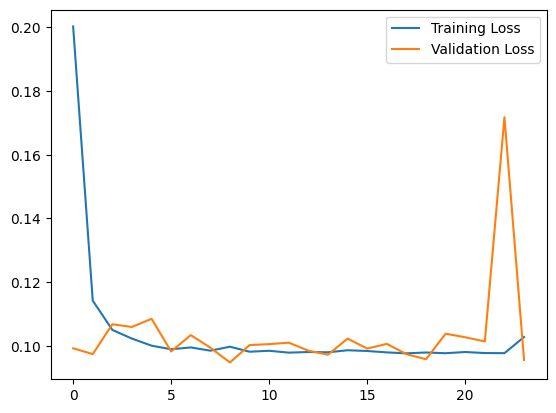

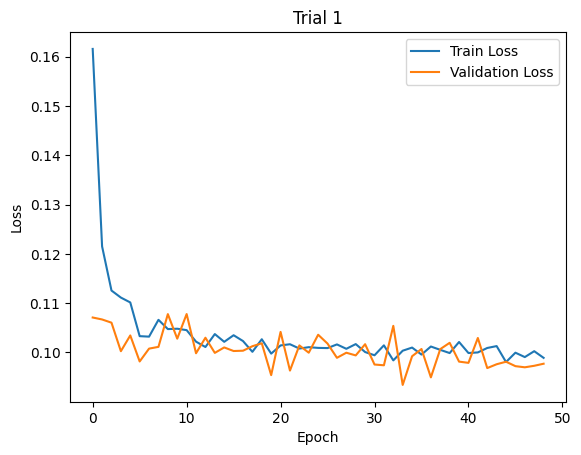

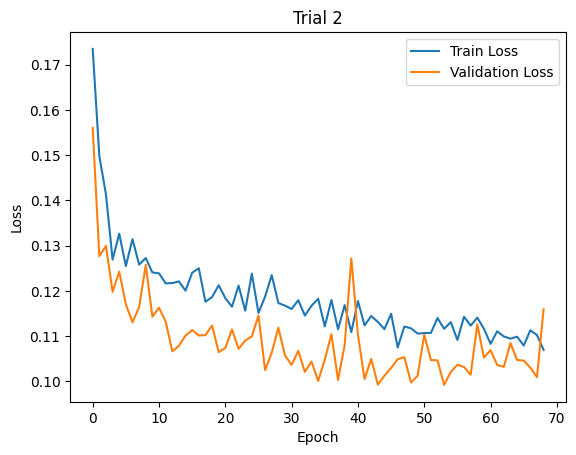

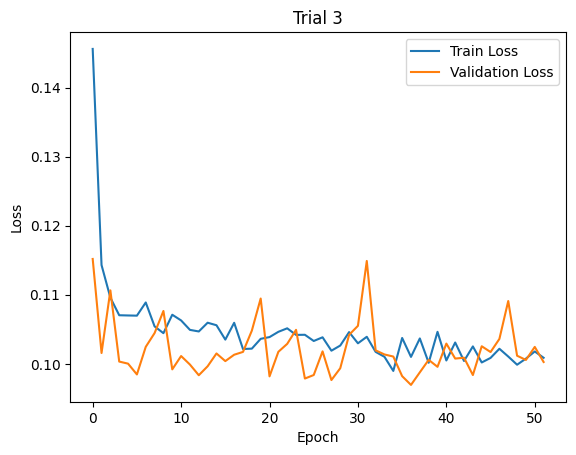

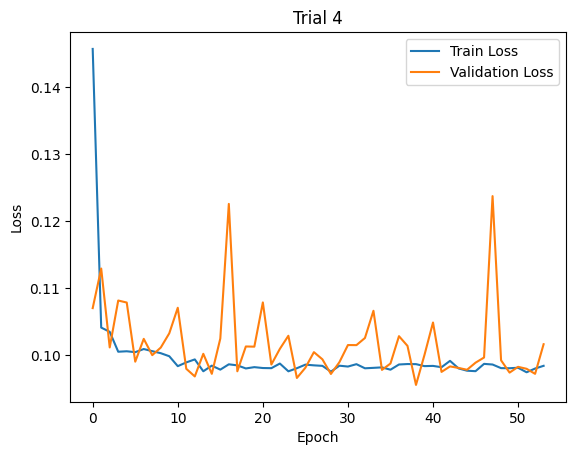

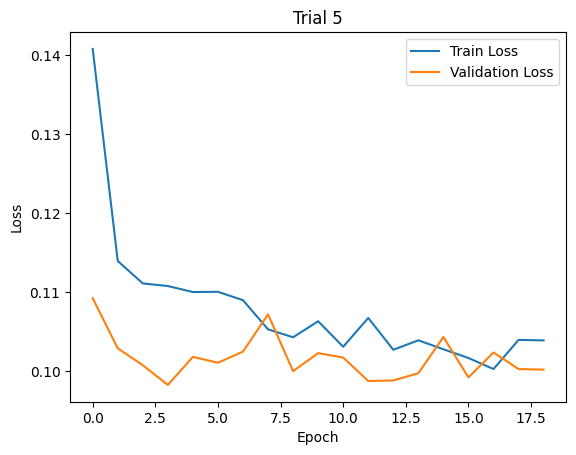

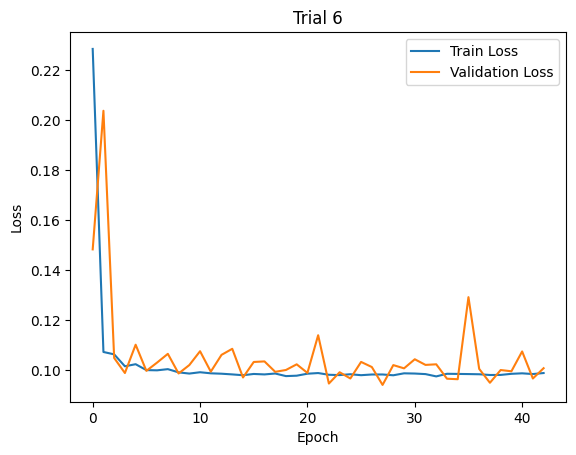

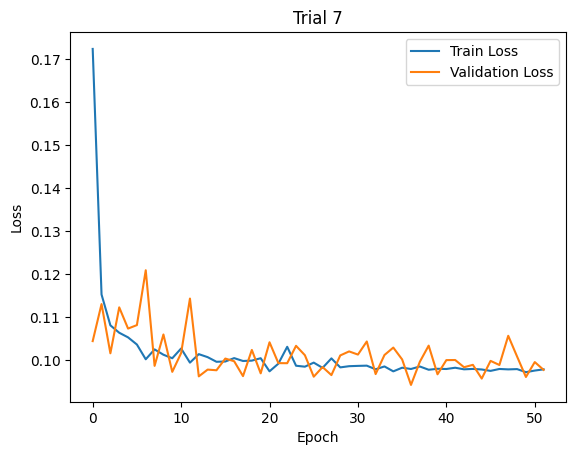

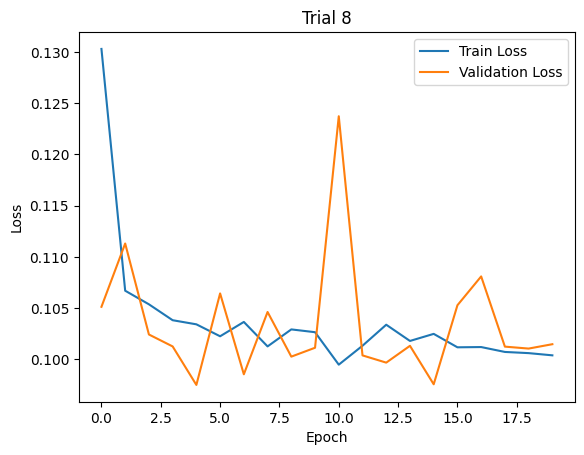

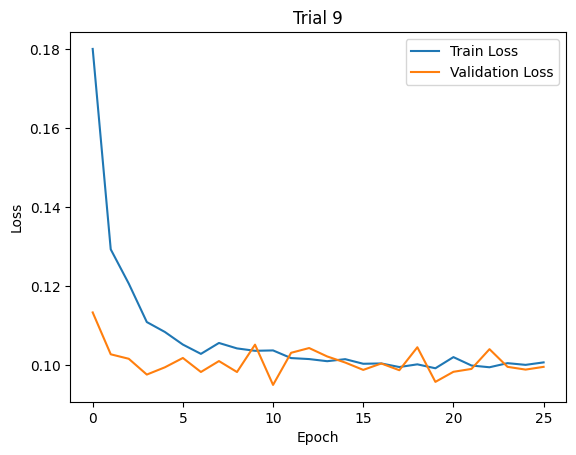

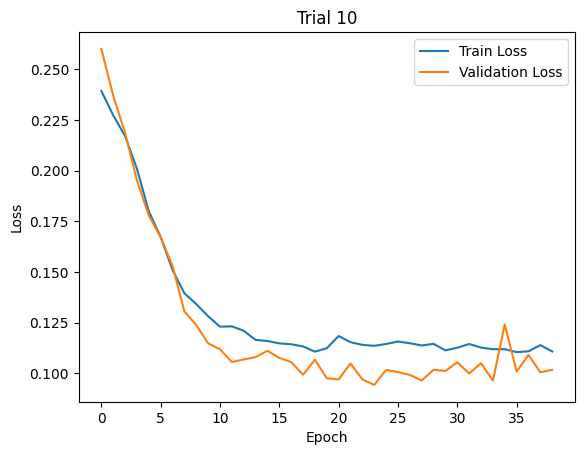

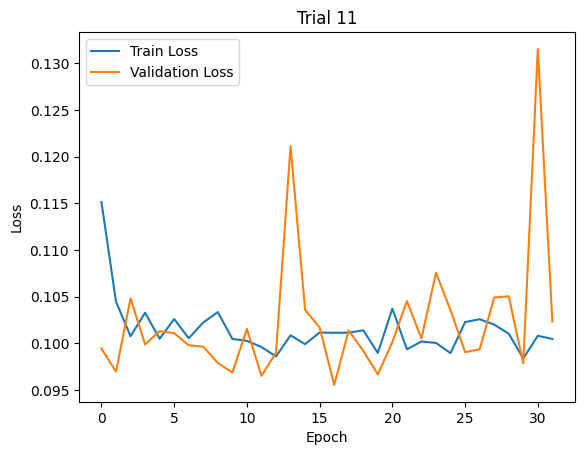

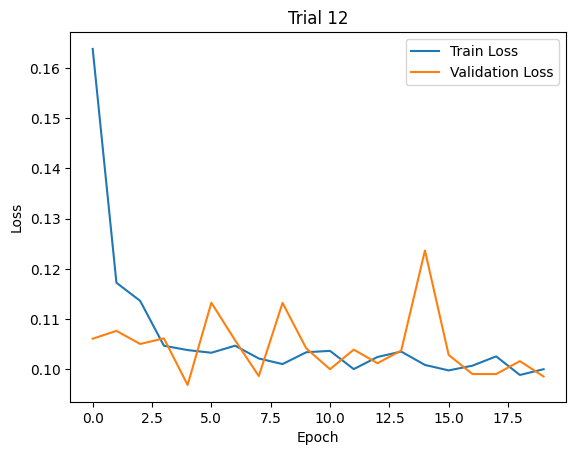

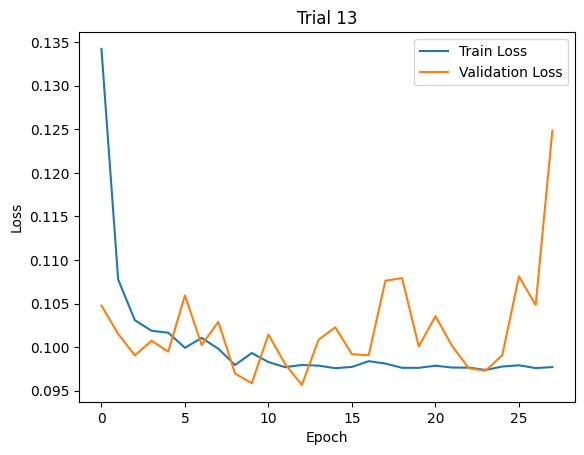

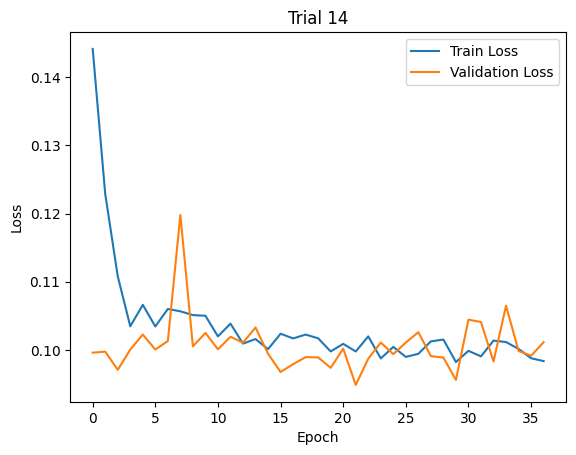

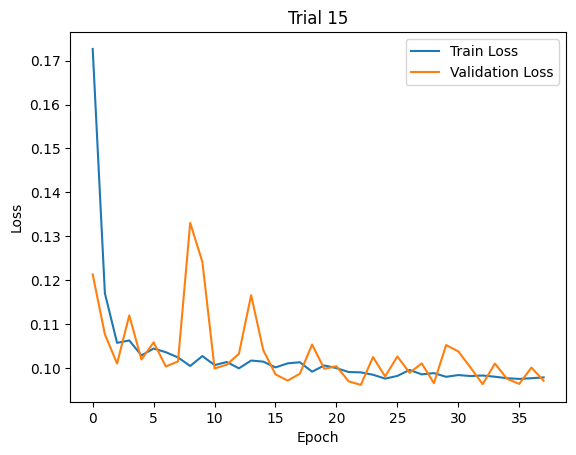

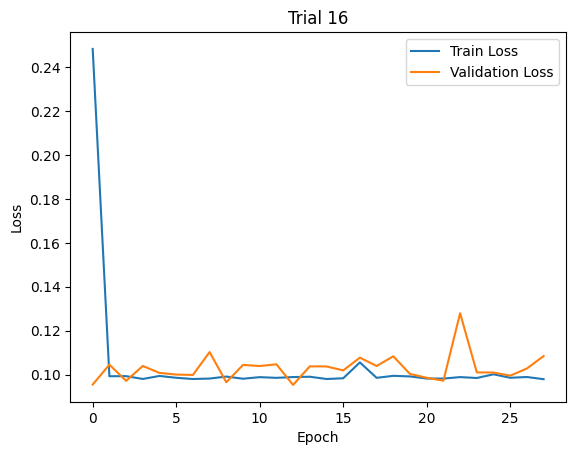

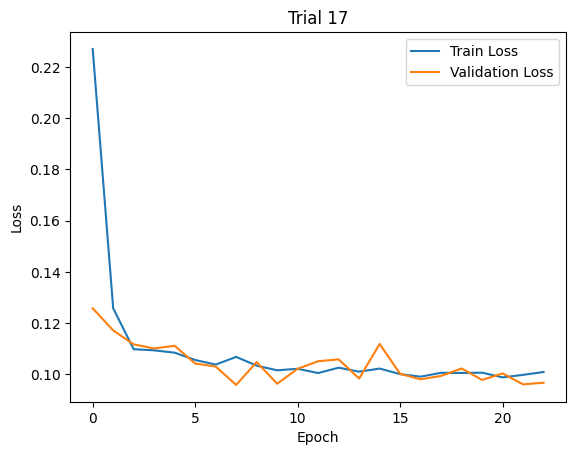

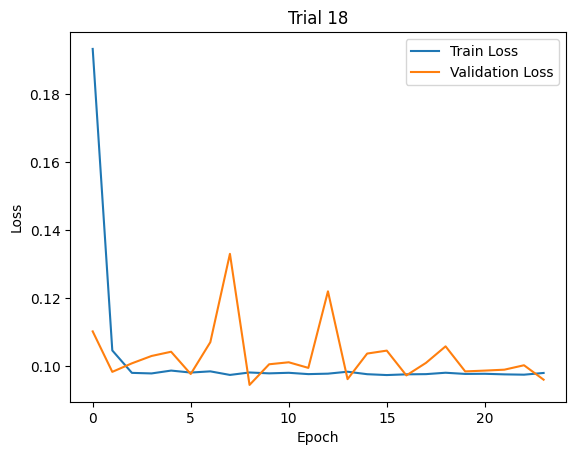

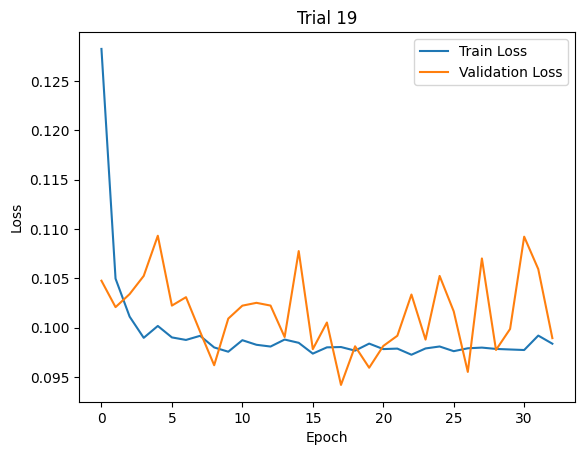

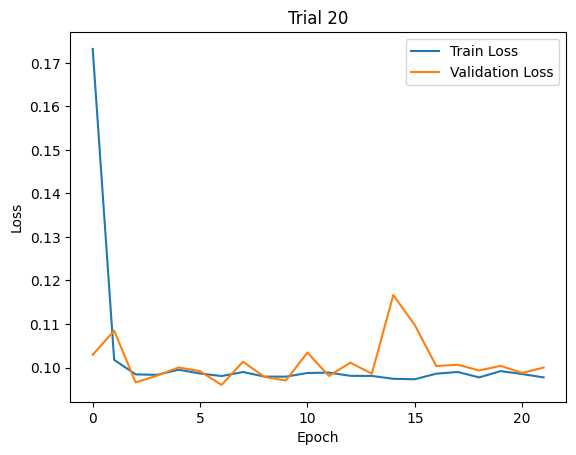

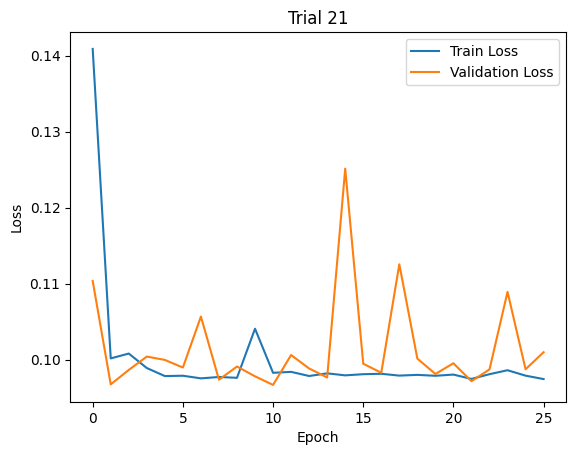

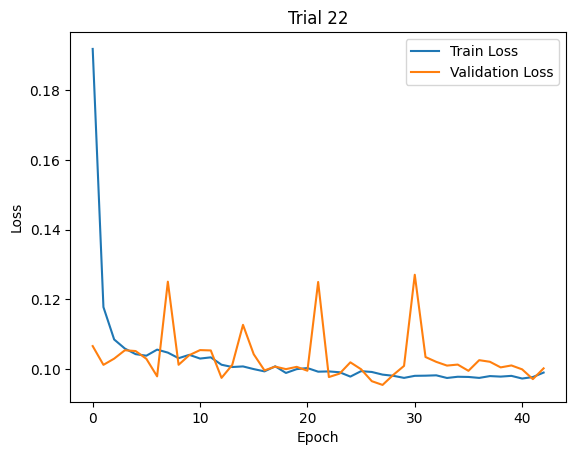

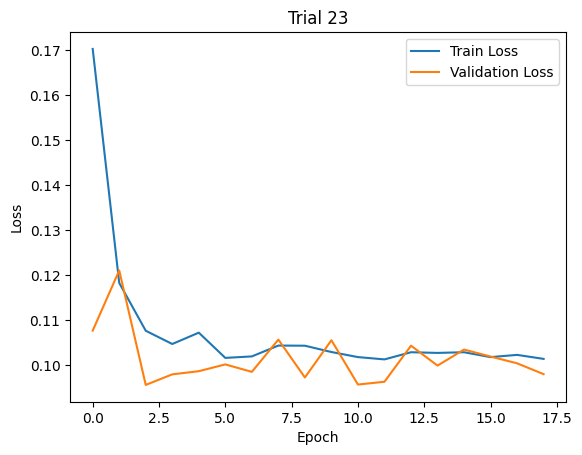

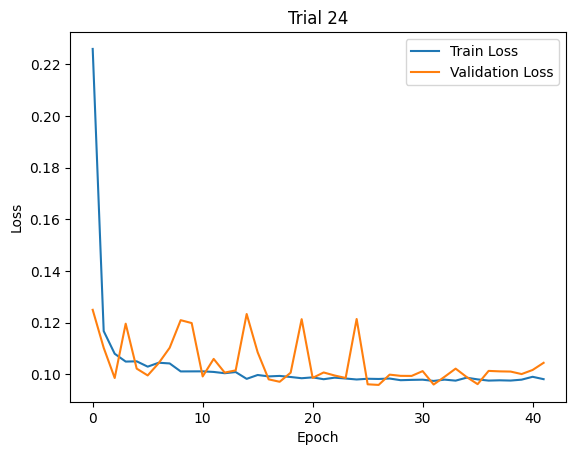

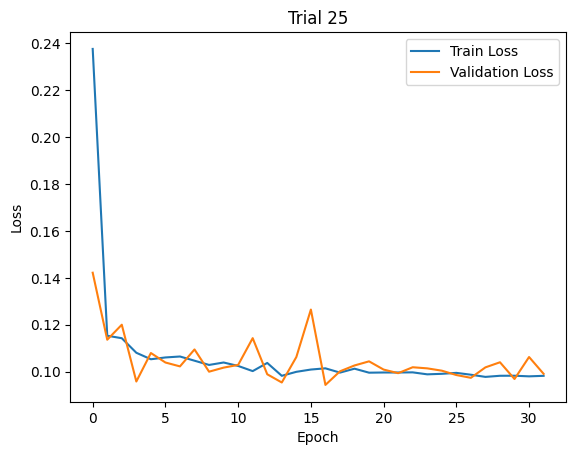

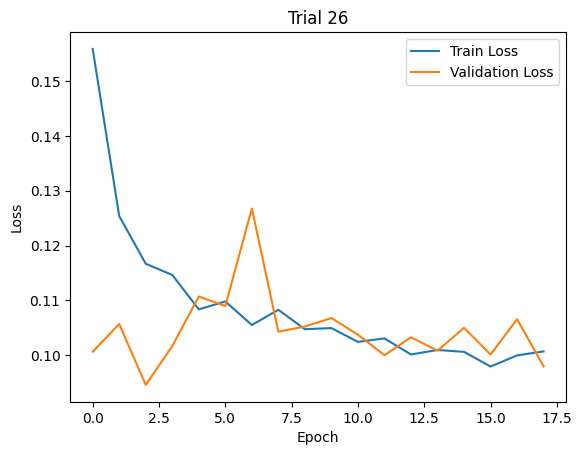

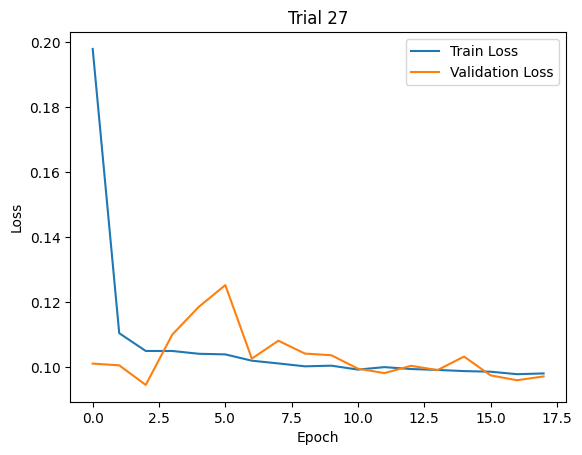

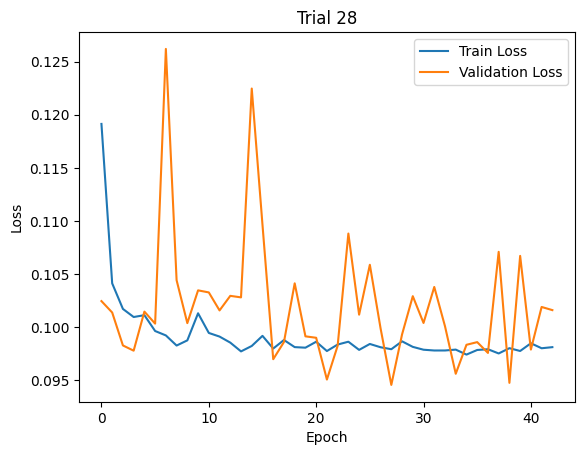

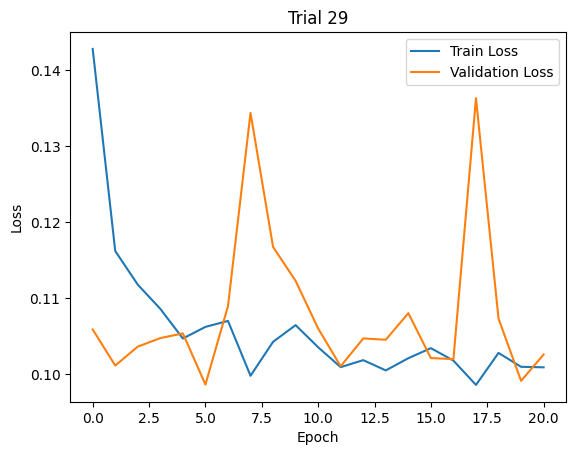

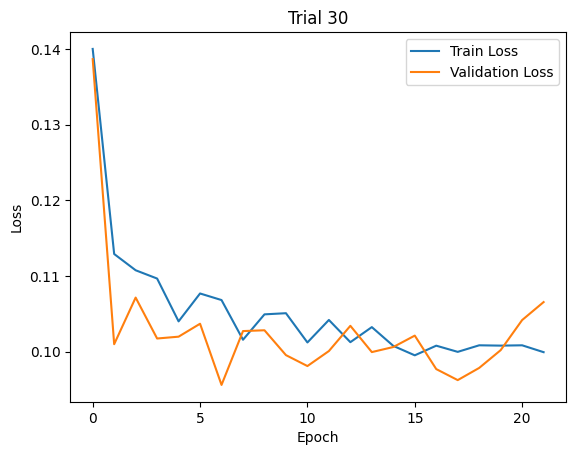

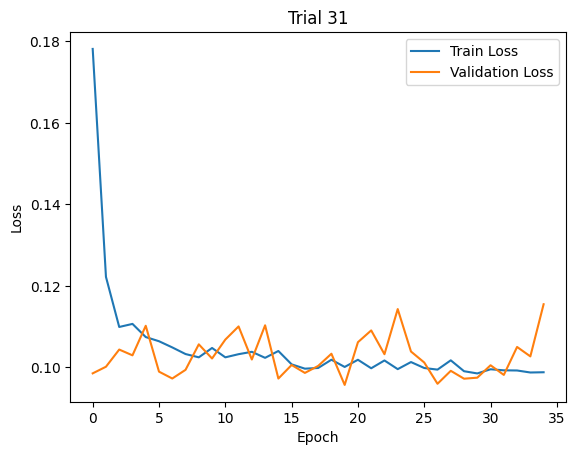

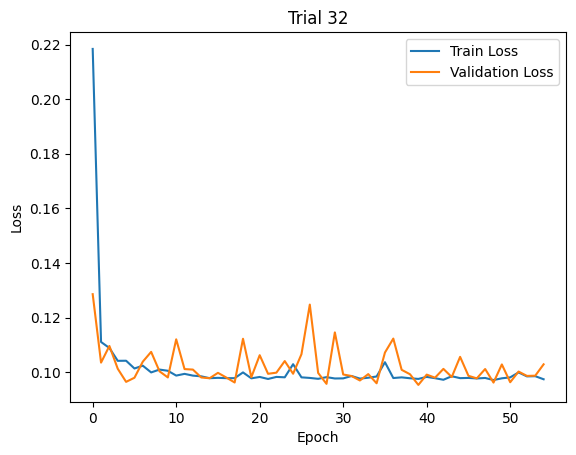

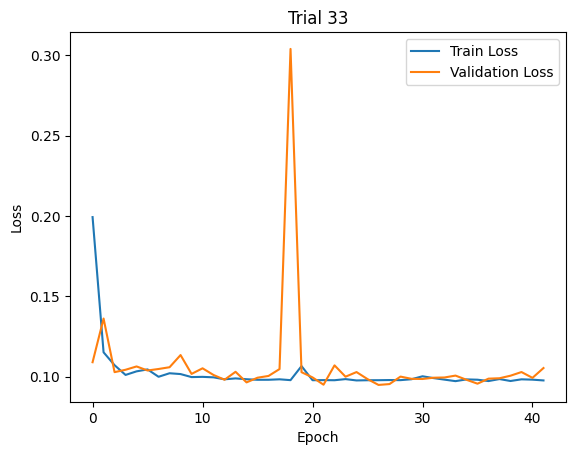

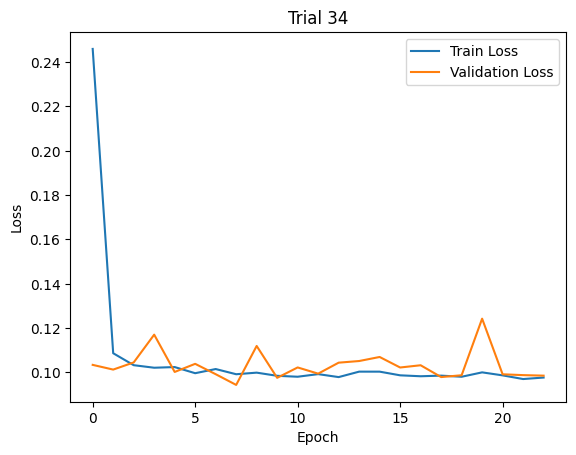

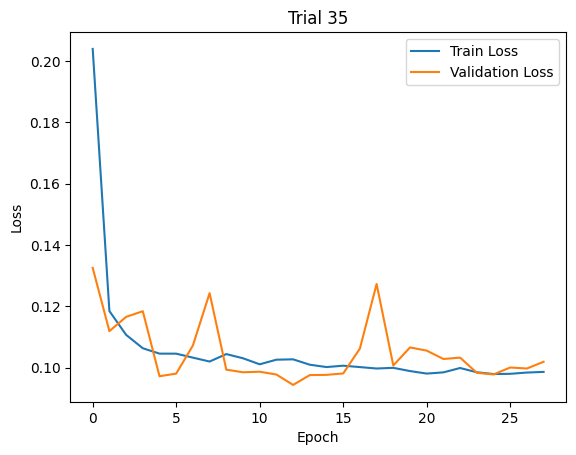

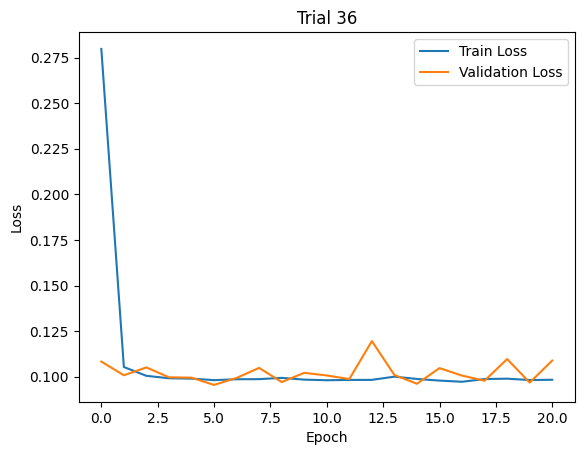

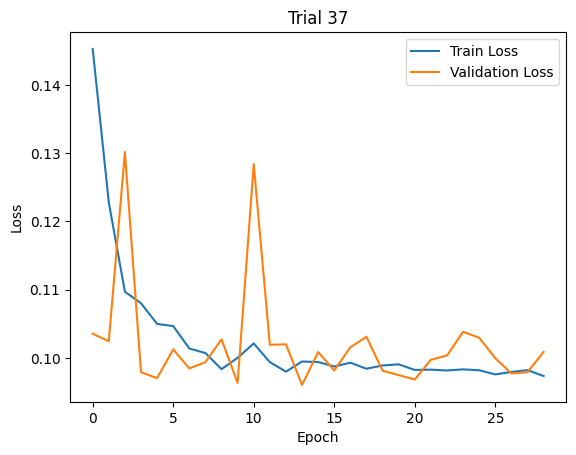

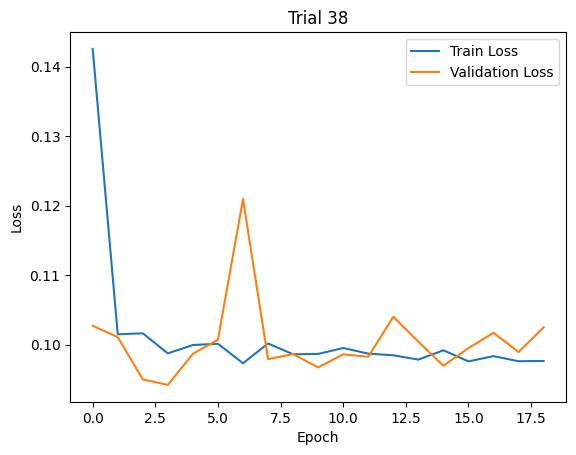

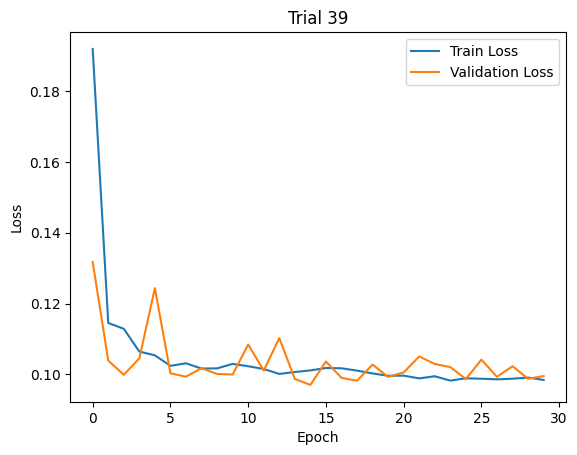

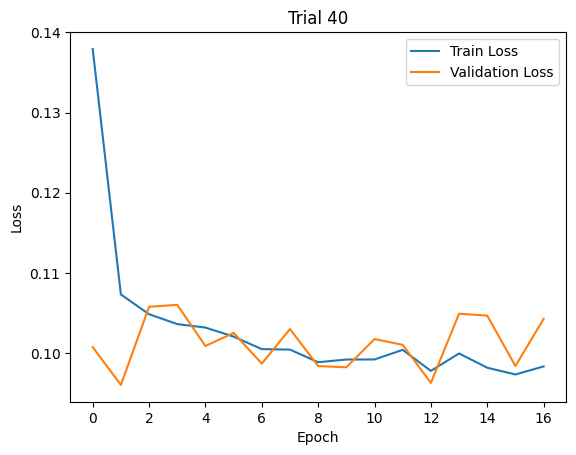

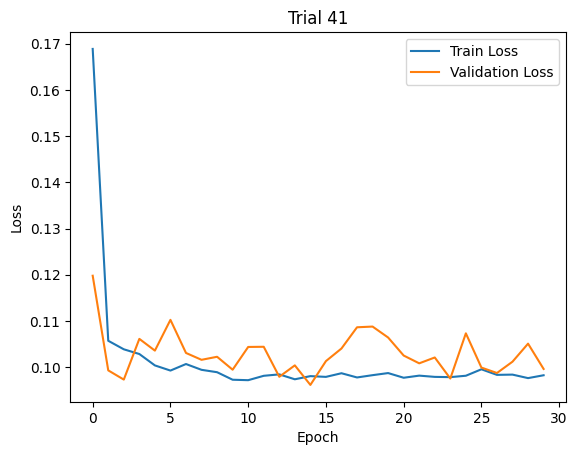

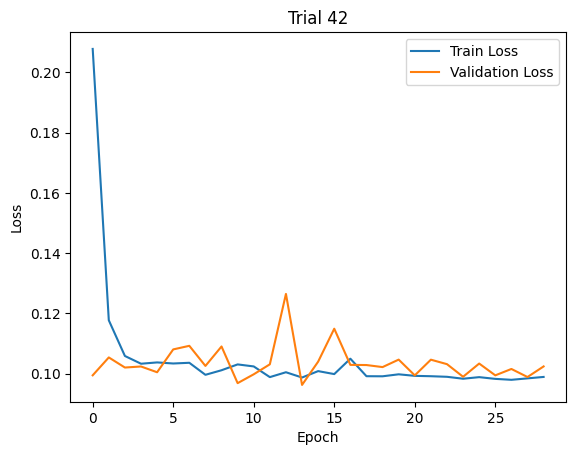

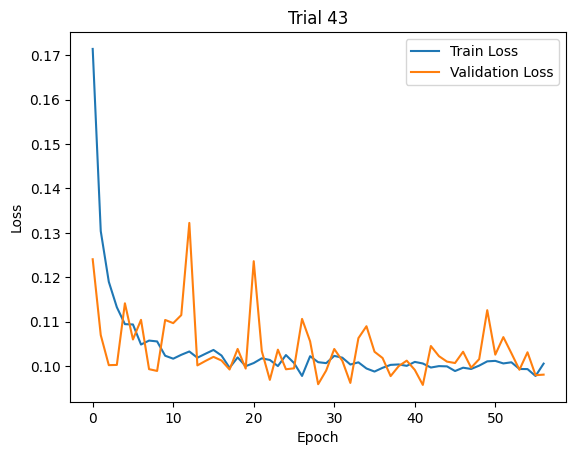

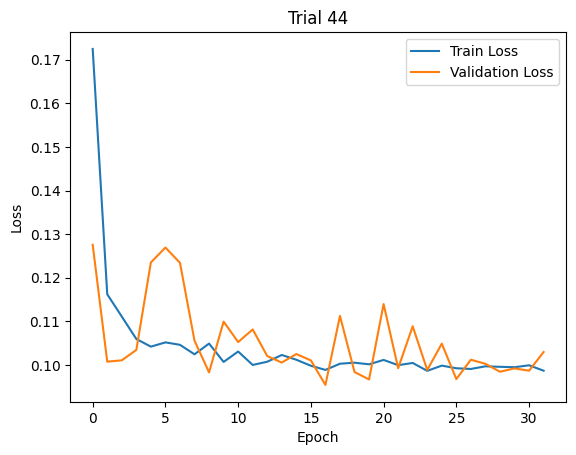

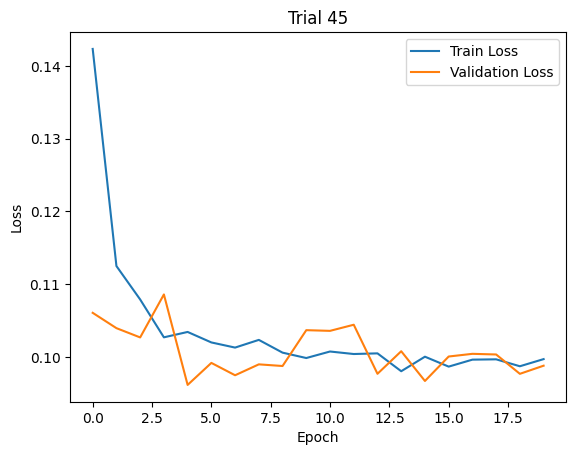

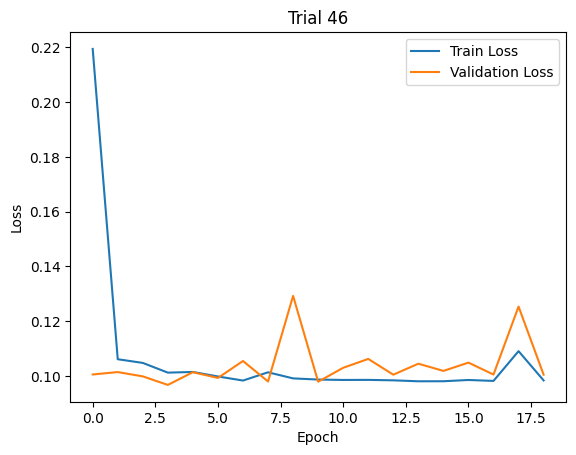

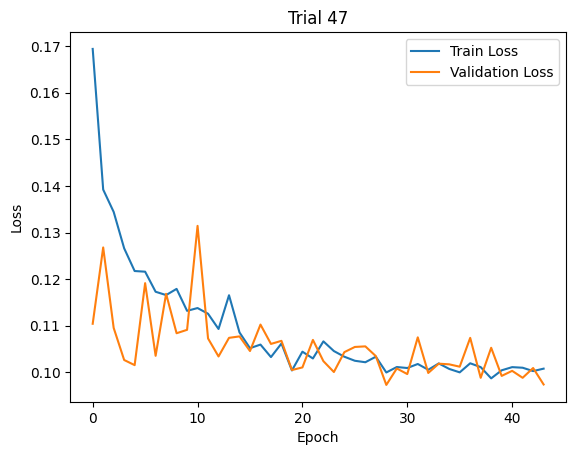

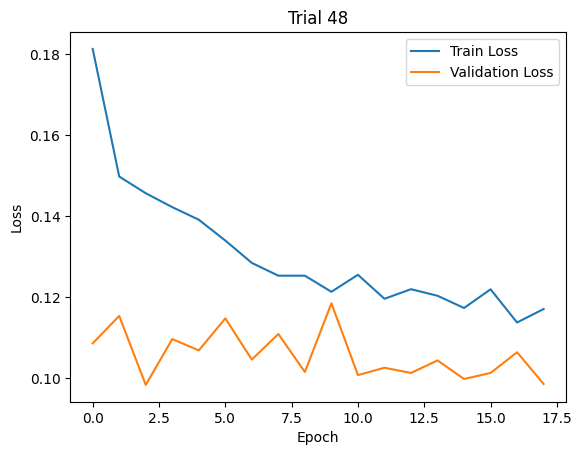

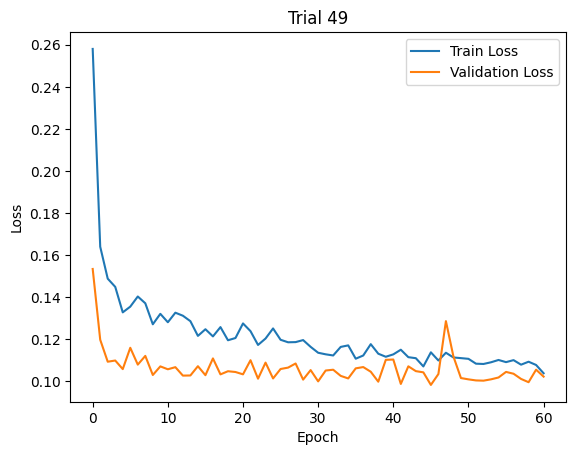

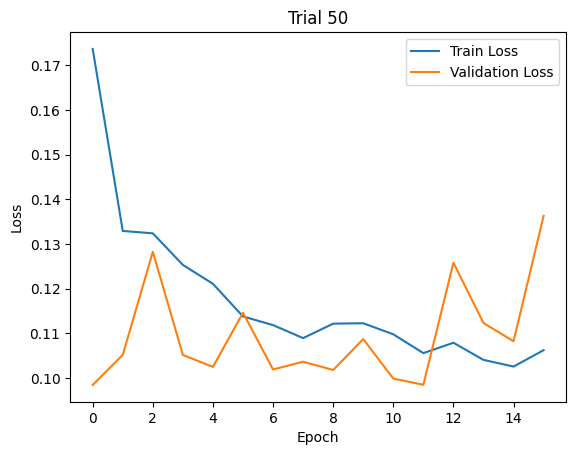

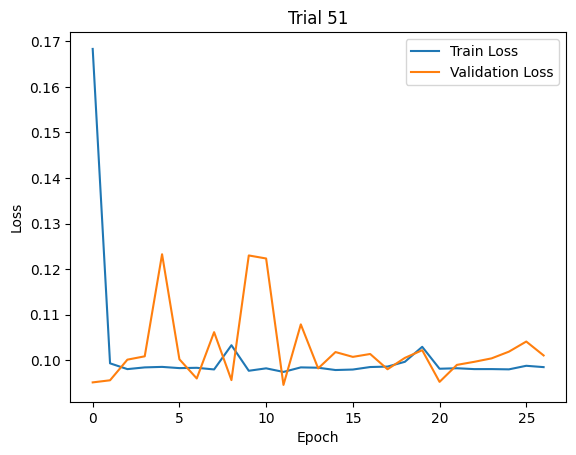

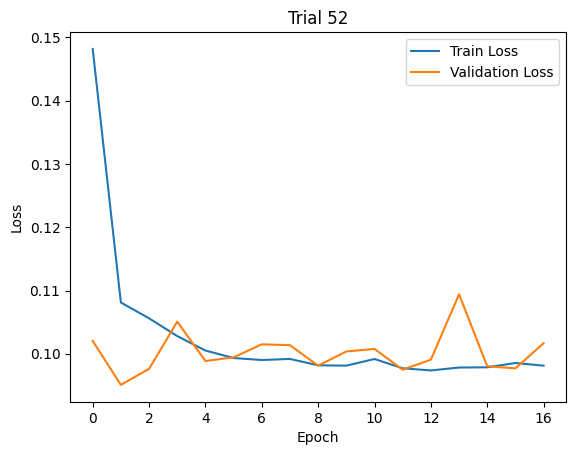

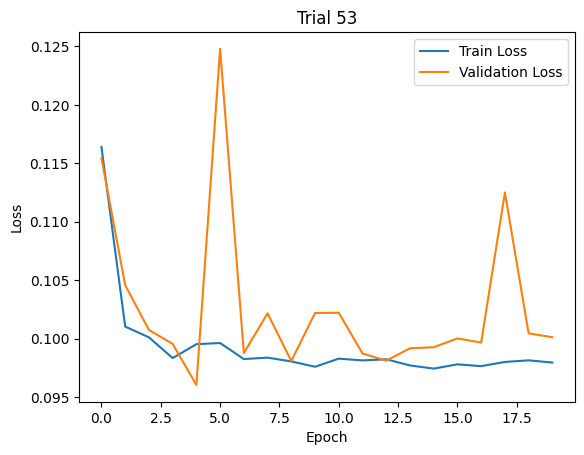

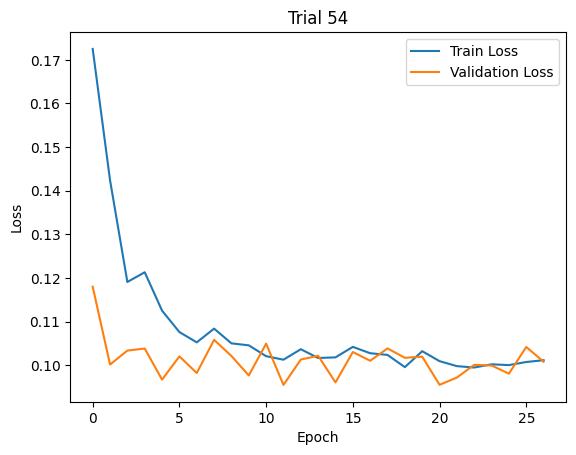

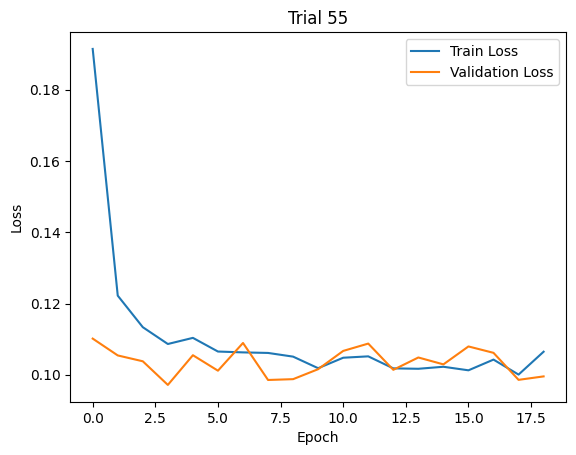

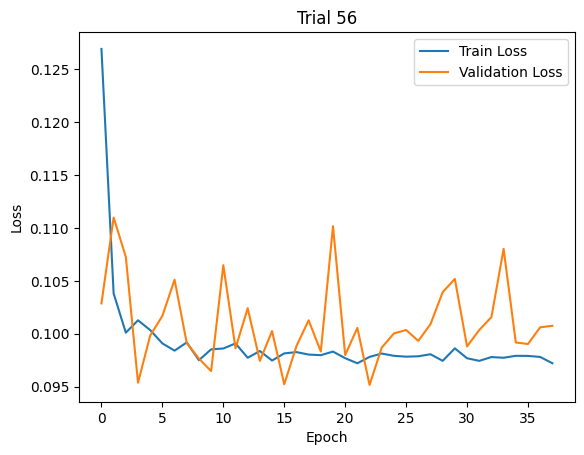

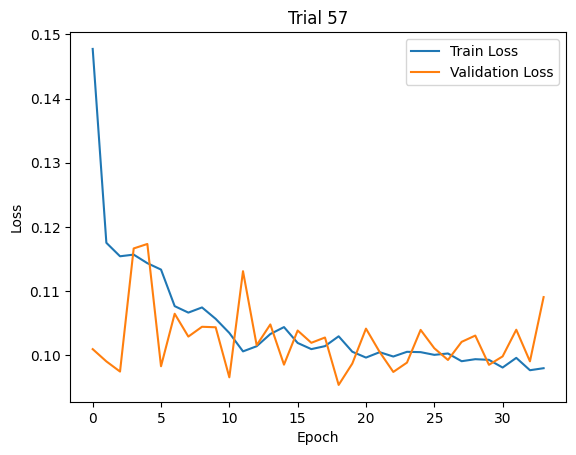

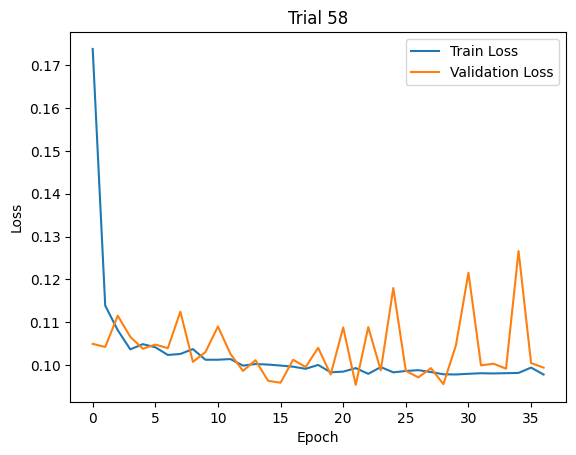

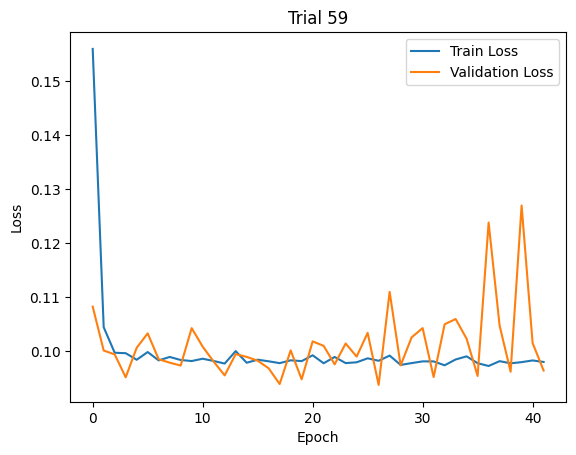

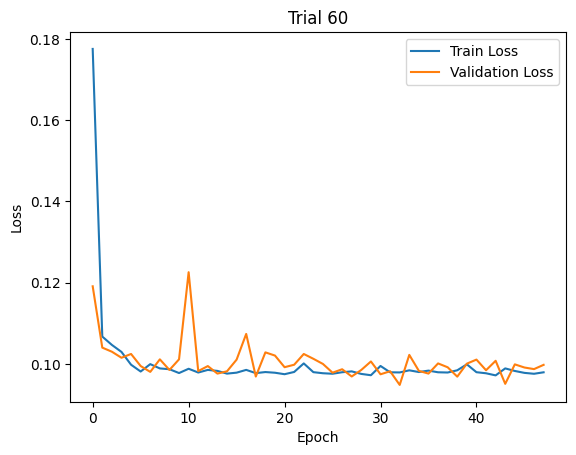

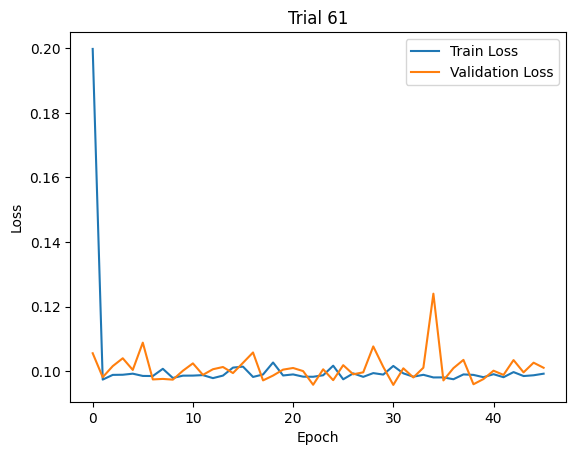

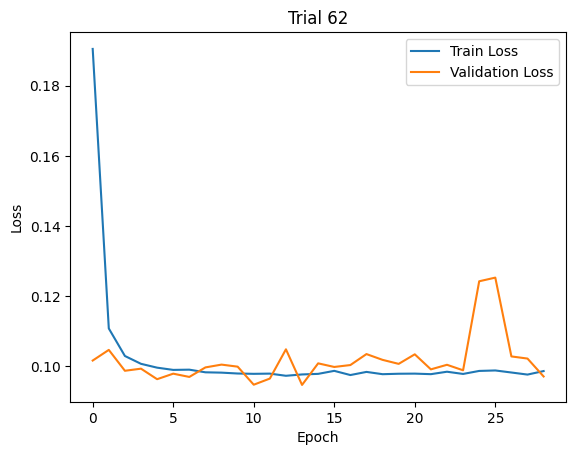

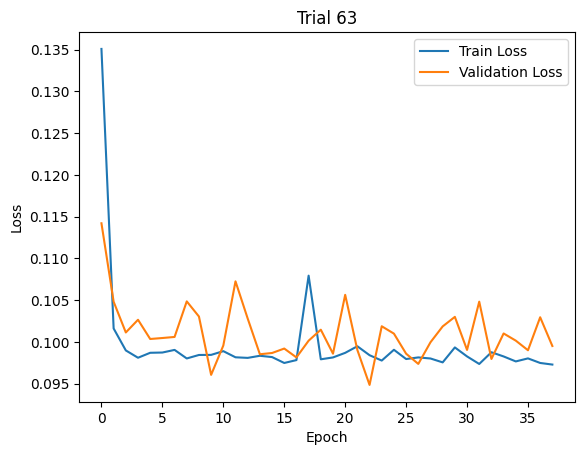

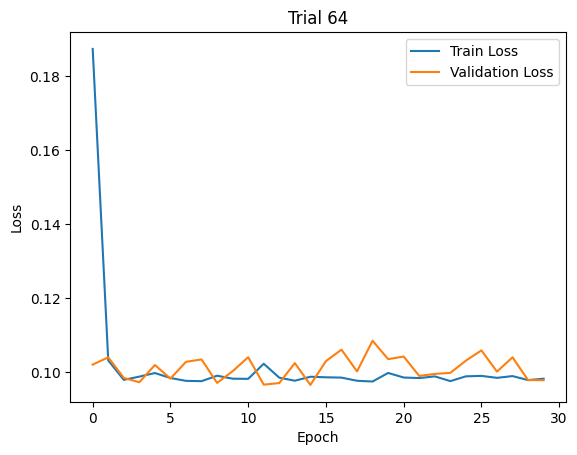

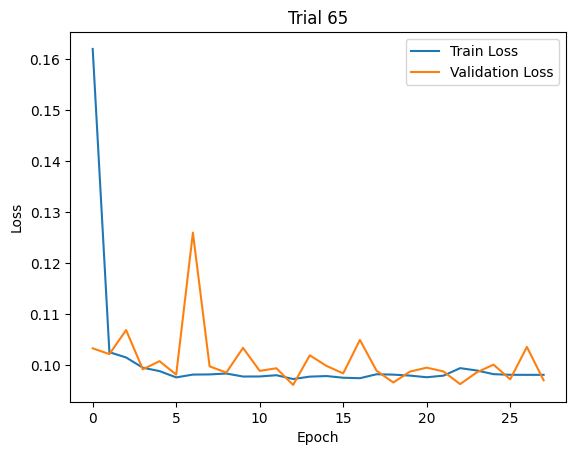

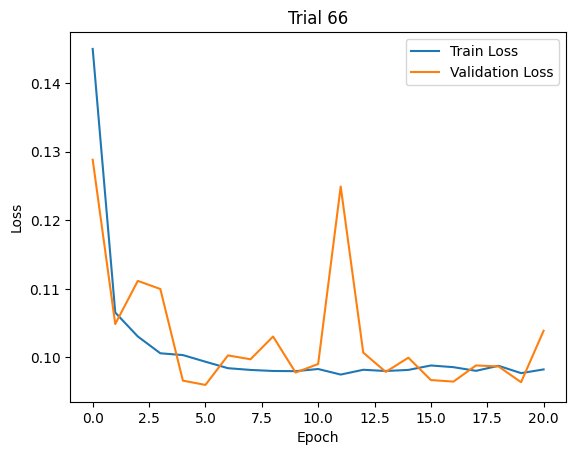

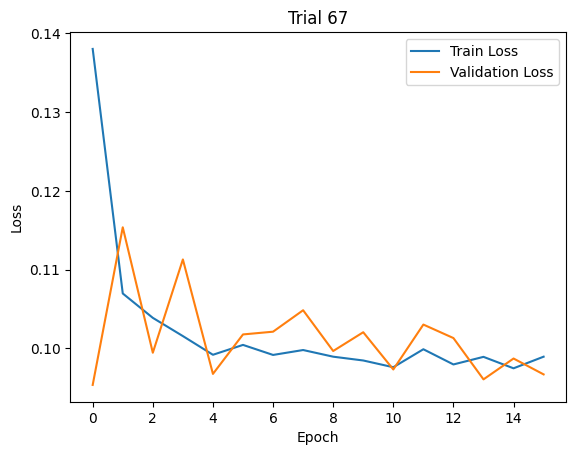

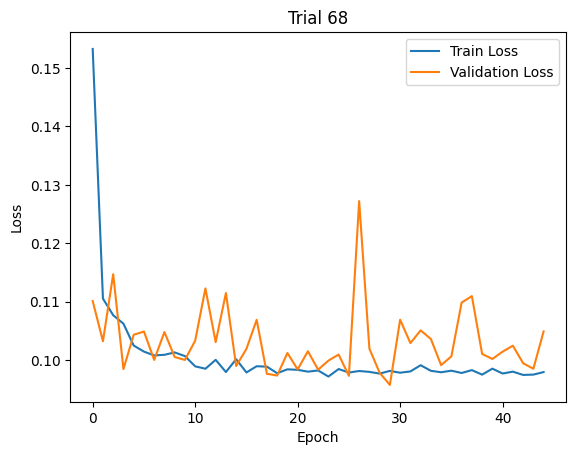

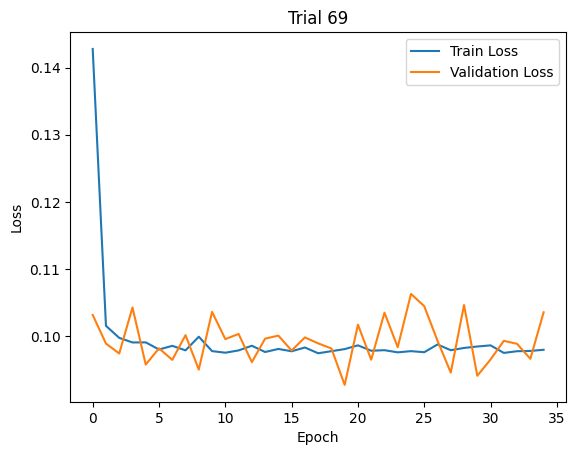

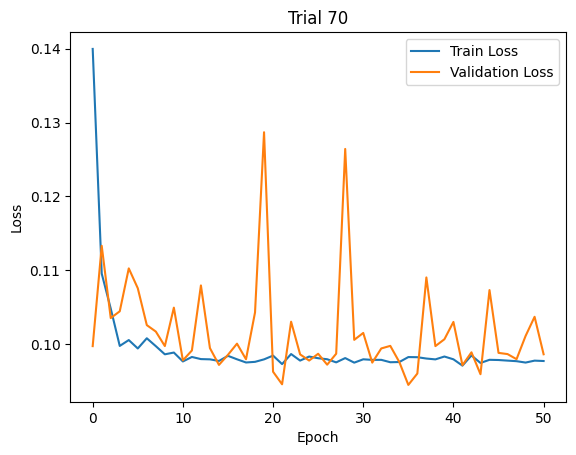

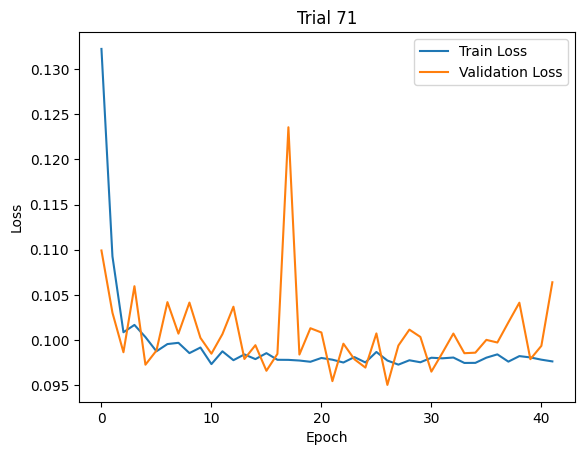

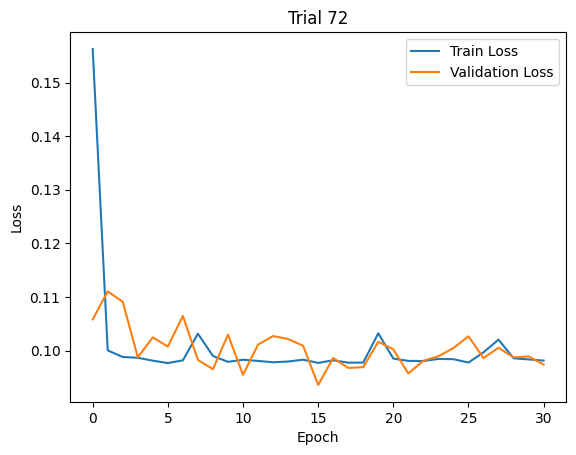

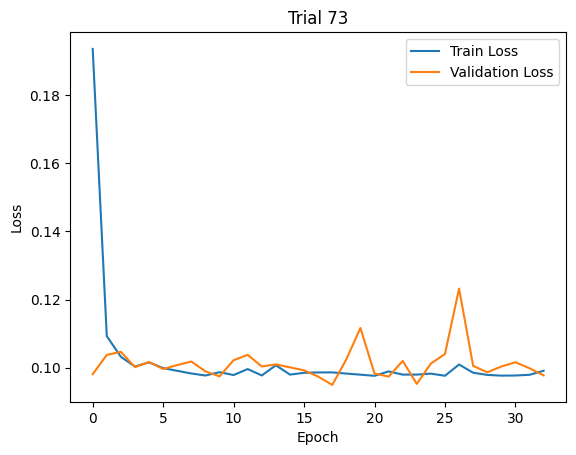

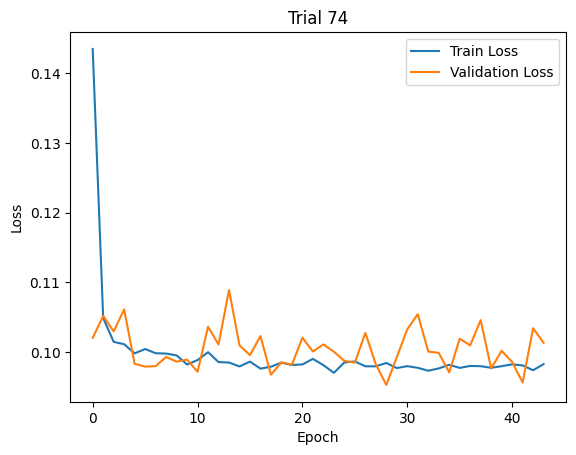

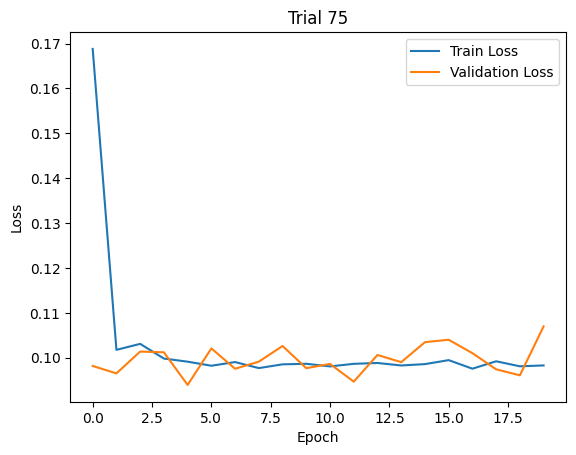

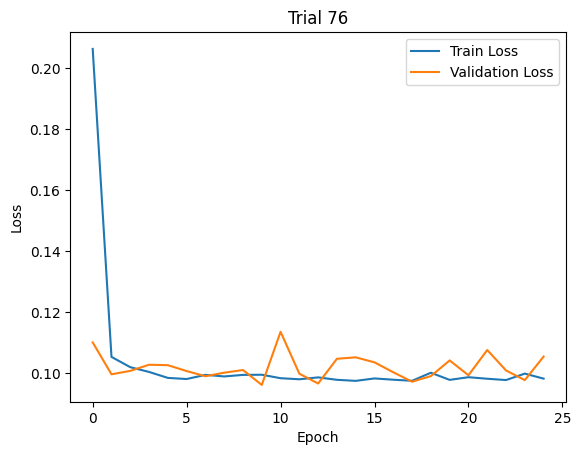

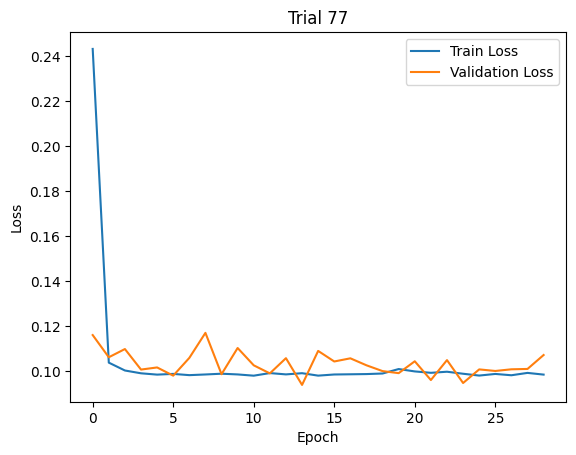

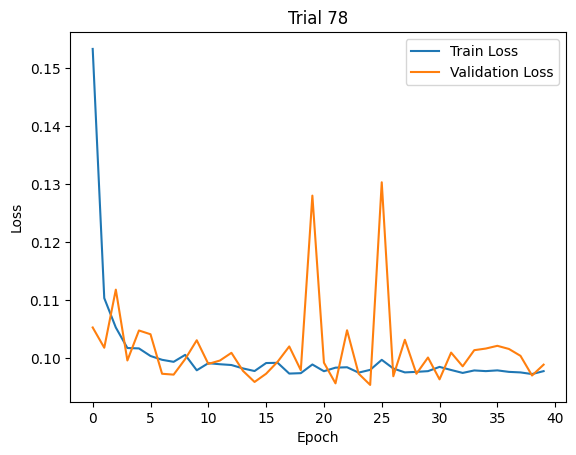

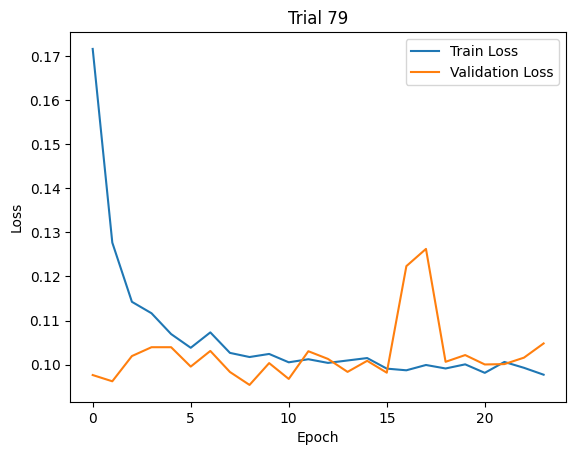

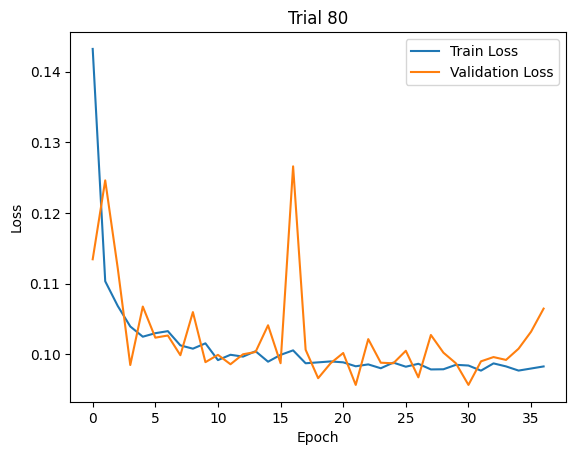

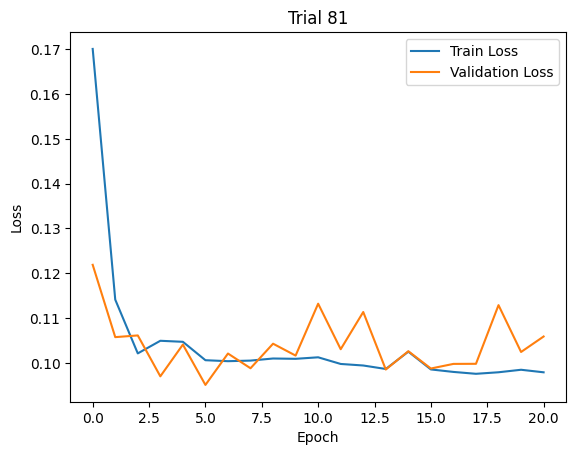

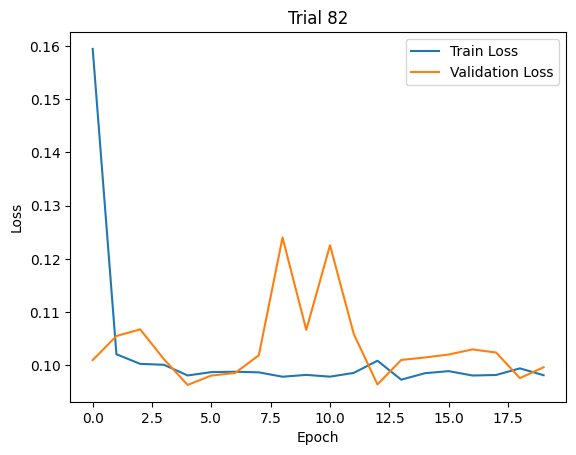

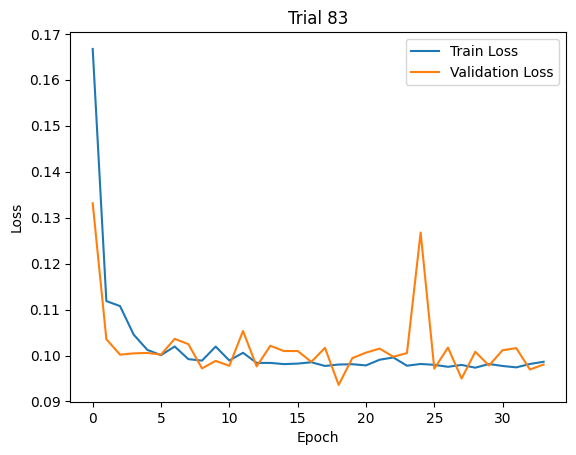

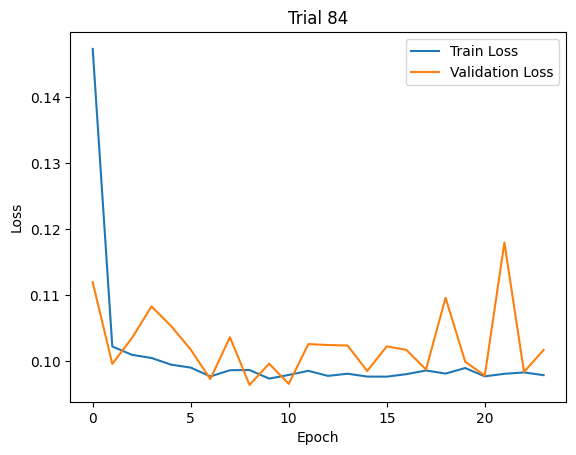

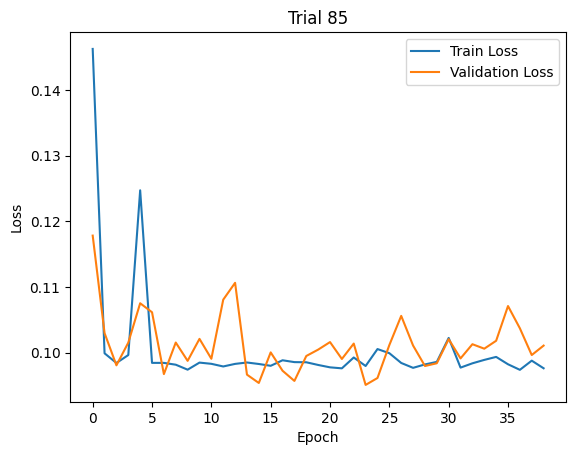

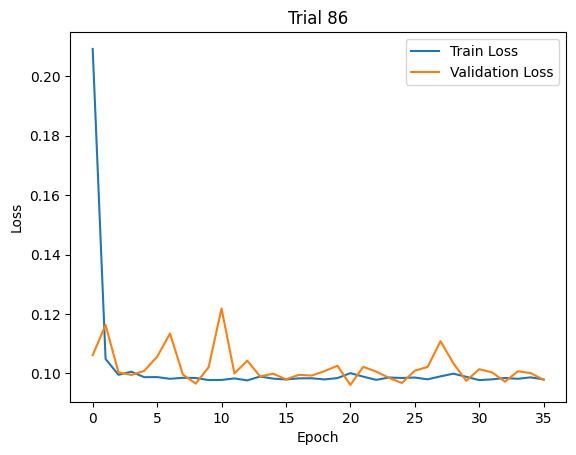

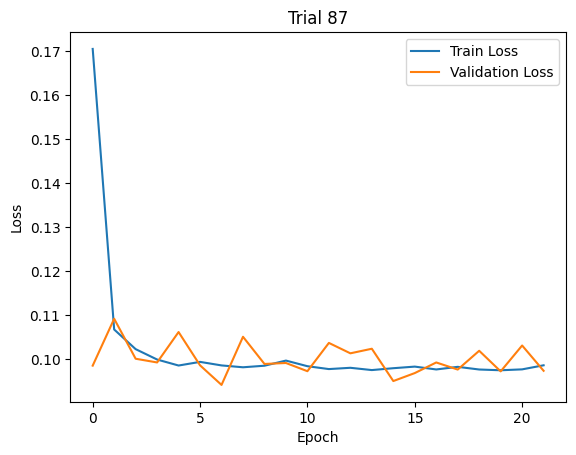

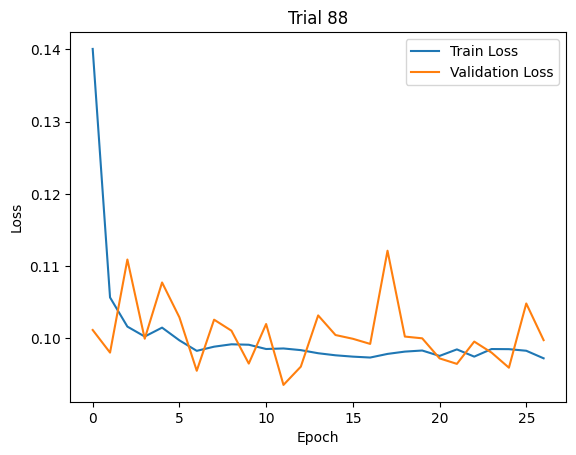

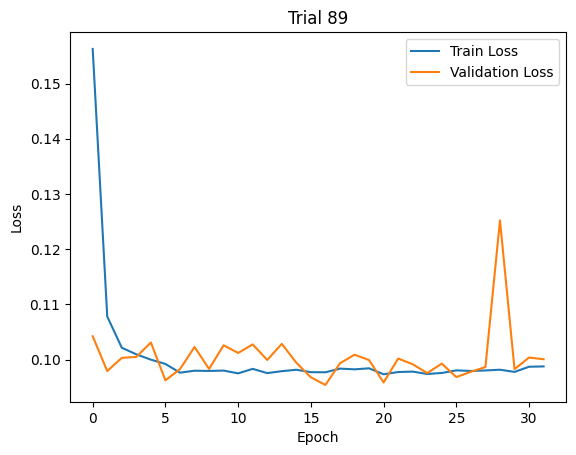

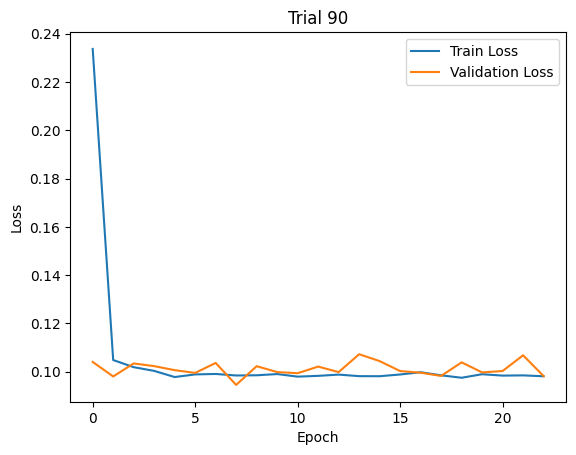

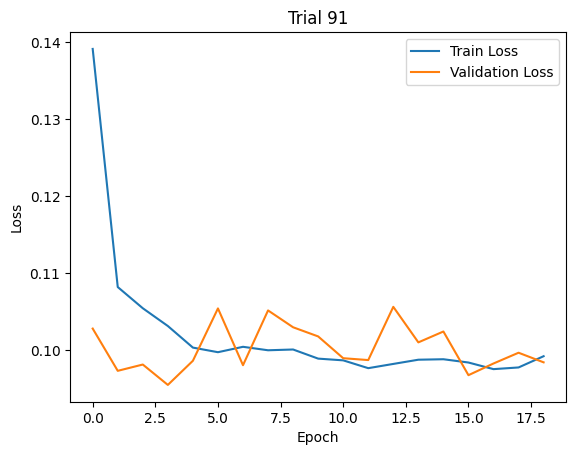

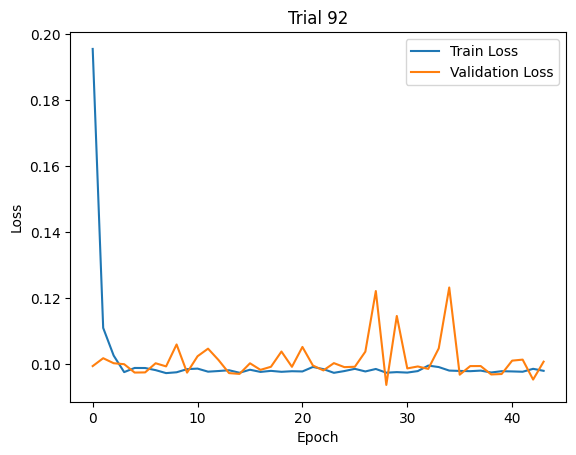

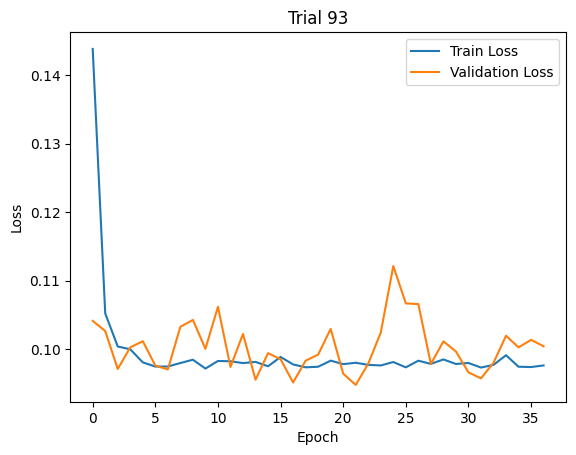

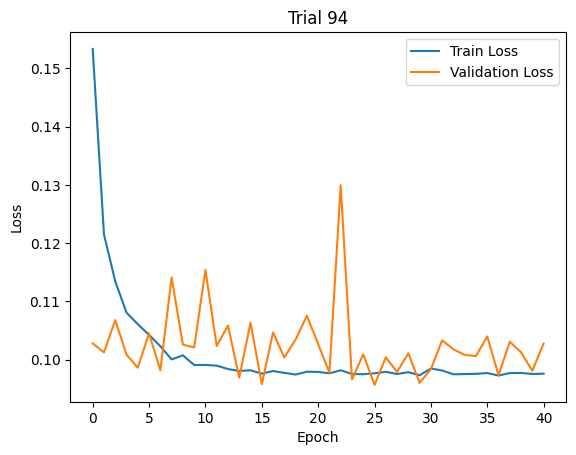

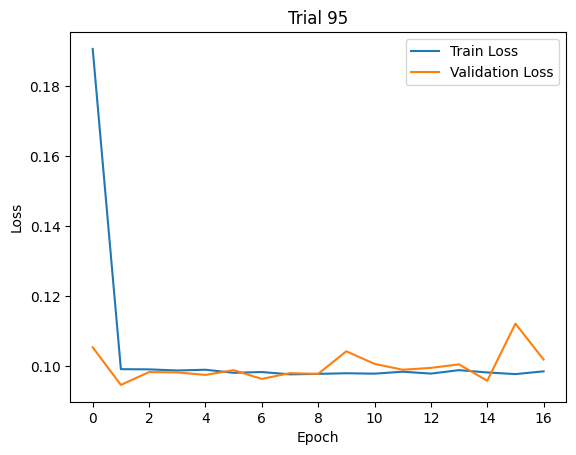

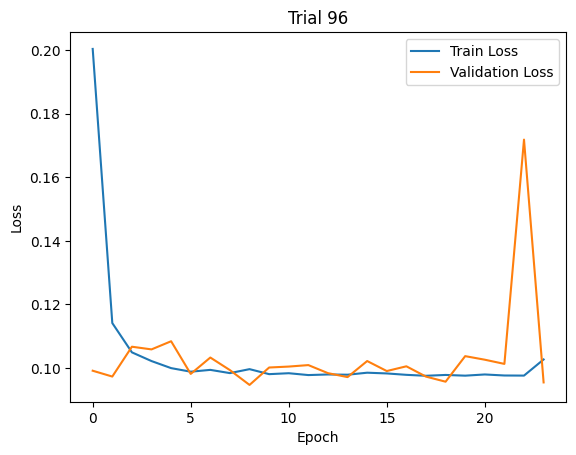

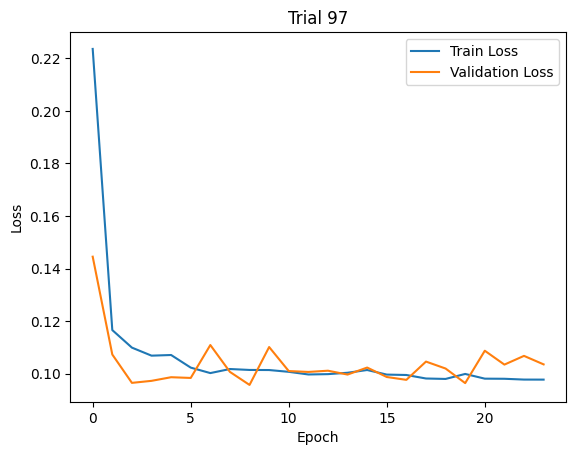

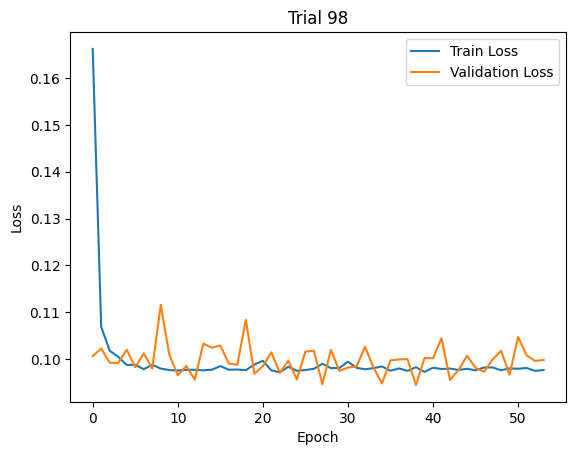

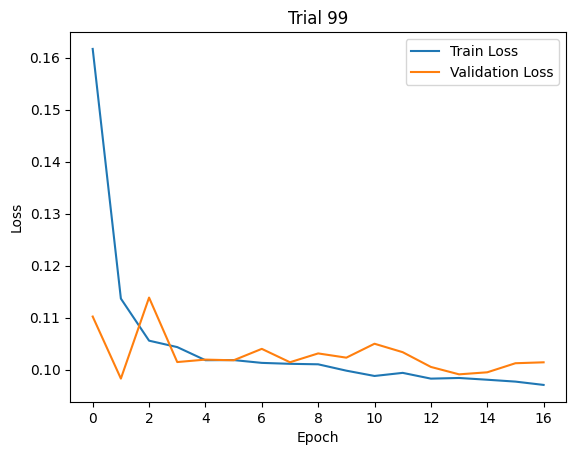

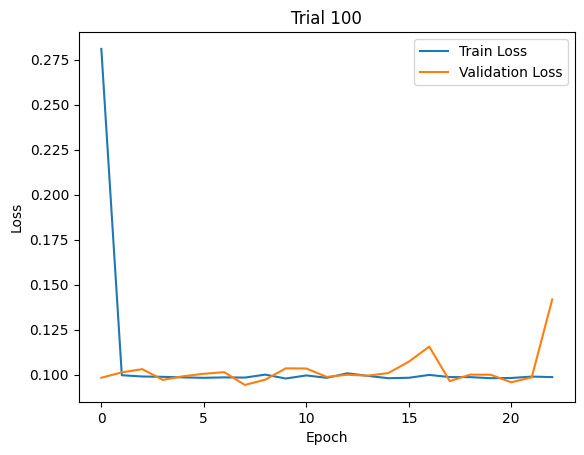

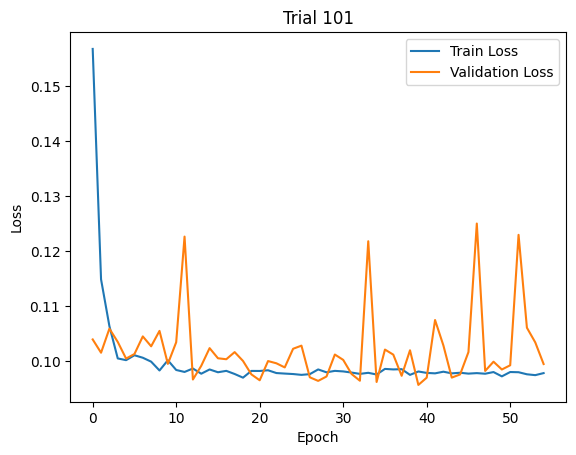

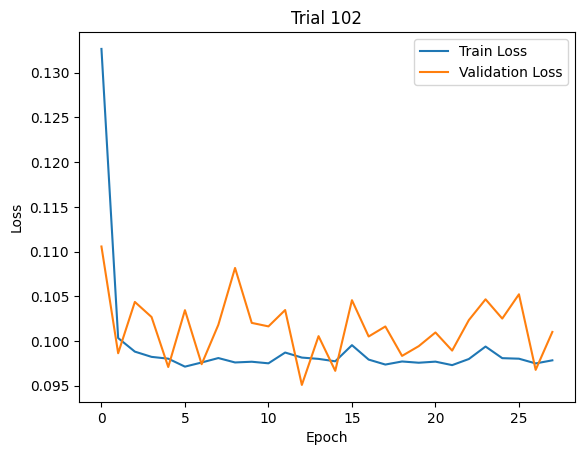

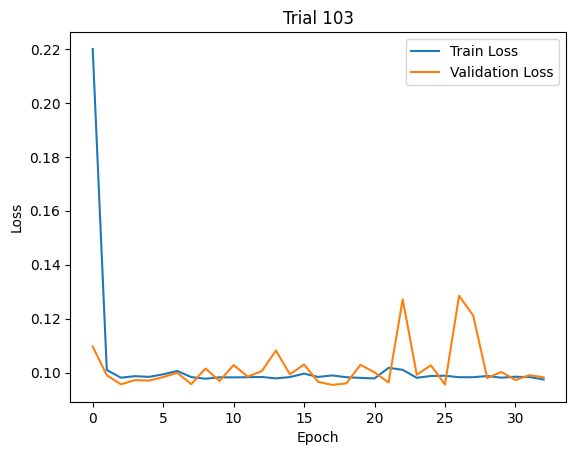

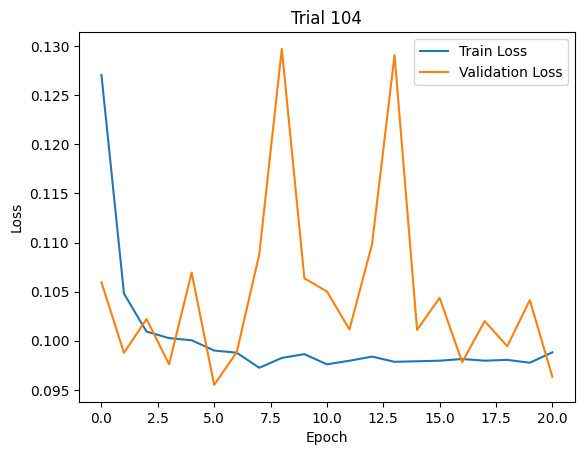

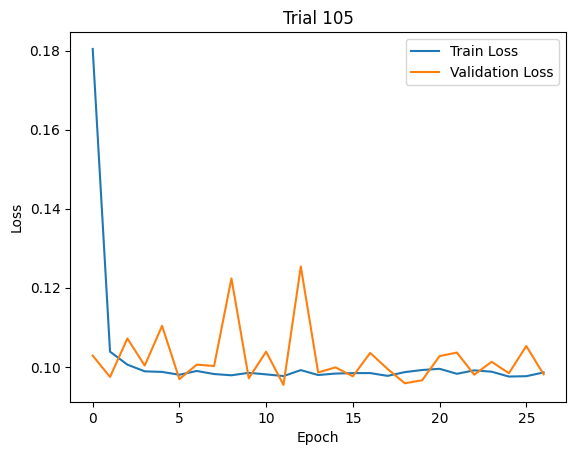

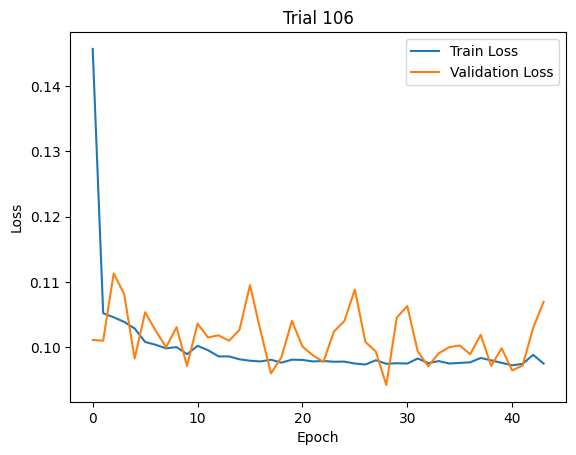

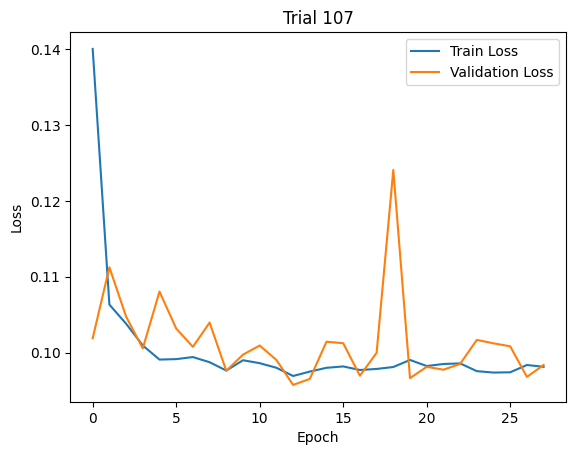

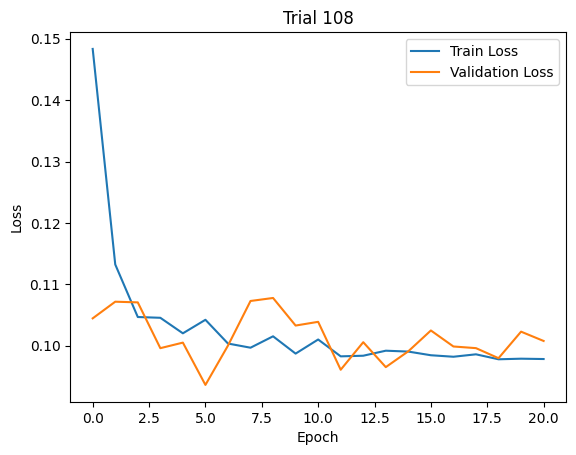

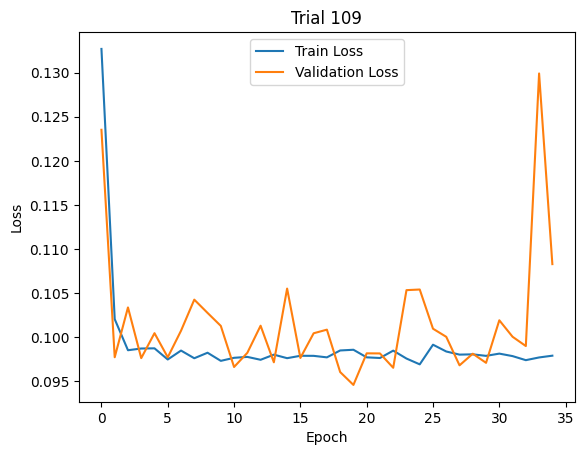

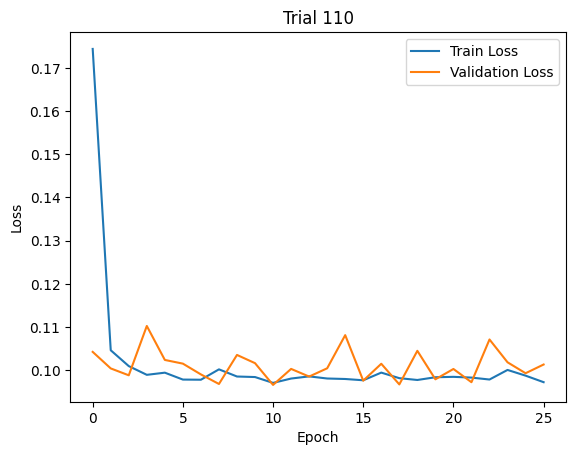

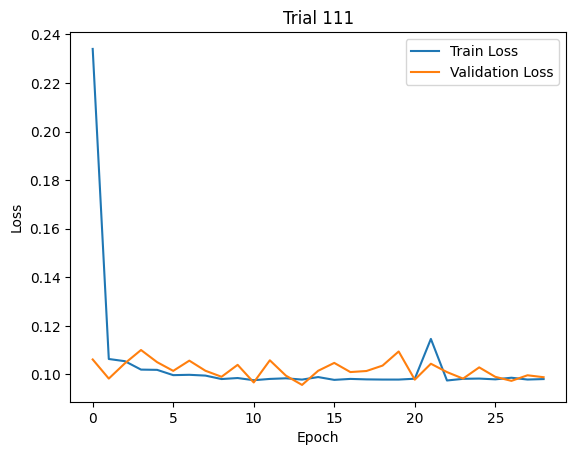

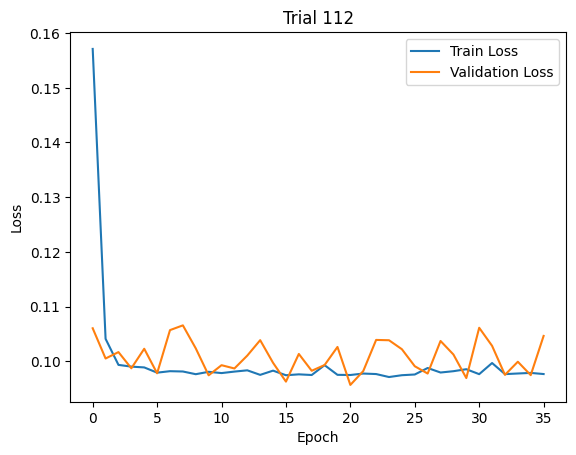

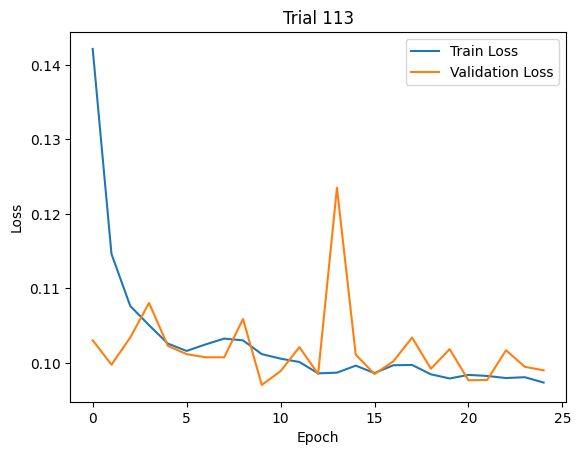

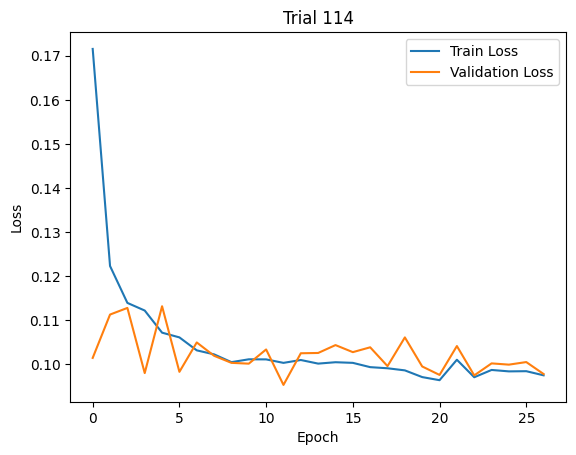

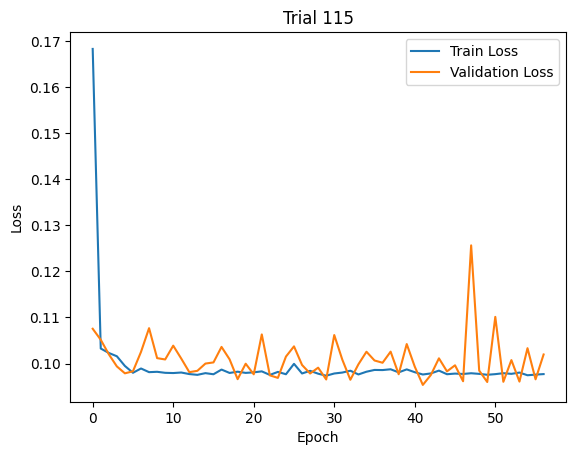

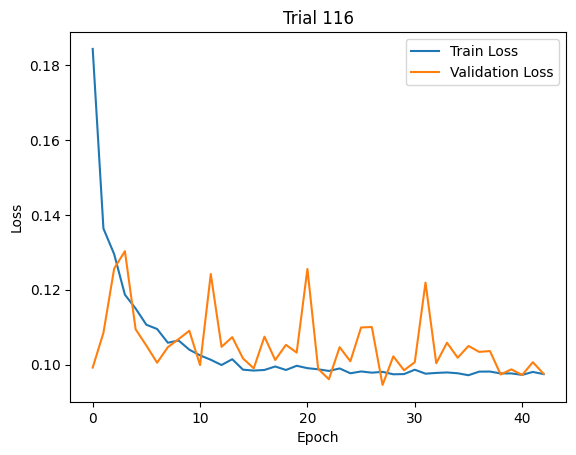

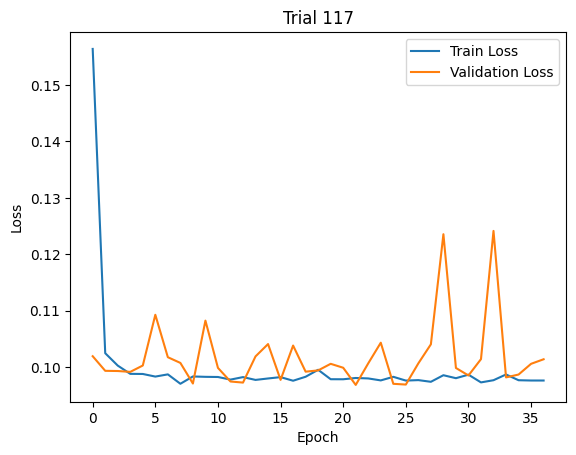

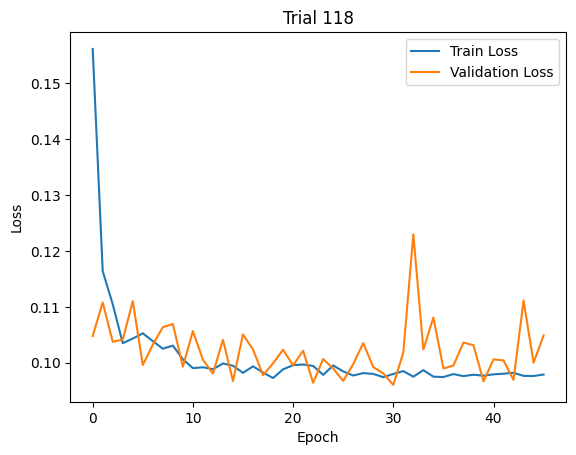

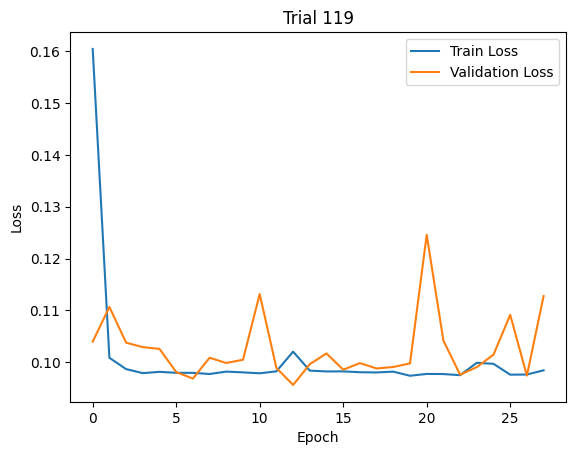

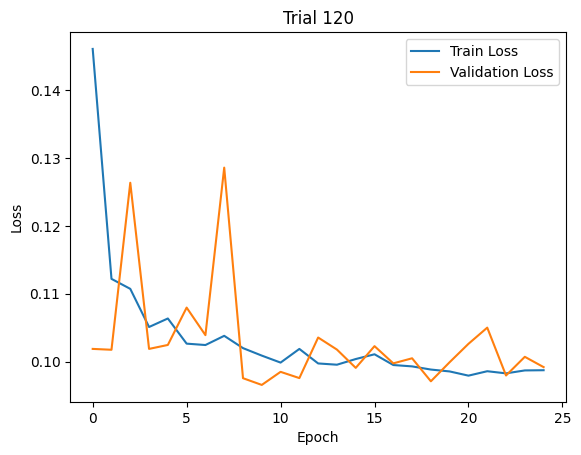

In [4]:
d_model_options = 3
nhead_options = [1,3]
num_layers_range = (1, 8)
dropout_range = (0.01, 0.5)
lr_range = (1e-5, 1e-2)
weight_decay = (1e-6, 1e-2)
num_hidden_layers_range=(1, 3)
hidden_dim_range=[32,64,128]
n_trials = 120
output_dim = 2
num_epochs = 1000
patience = 15
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
device = torch.device('cuda')
objective = Objective(train_loader, valid_loader, device, d_model_options, nhead_options, num_layers_range, dropout_range, lr_range, n_trials, output_dim, num_epochs, patience, weight_decay,num_hidden_layers_range,hidden_dim_range)
best_value, best_params = objective.optimize()
objective.plot_losses()

In [5]:
print(f"Best trial:")
print(f"  Value: {best_value:.4f}")
print(f"  Params: {best_params}")

Best trial:
  Value: 0.0955
  Params: {'nhead': 1, 'weight_decay': 1.0124007819891527e-05, 'num_layers': 3, 'dropout': 0.44174912484556766, 'lr': 0.003980816524933235, 'num_hidden_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 64, 'd_model': 3, 'hidden_layers': [128, 64]}


In [6]:
#processor1 = DataProcessor(data, output_data,seed1=42,seed2 = 17)
#train_data1, val_data1, test_data1, train_indices1, val_indices1, test_indices1 = processor1.process_padded_data()
#dataset1 = pd.read_excel(r'F:\junwei\dataset\_MASTER_MAFAI2023_456cases.xlsx')

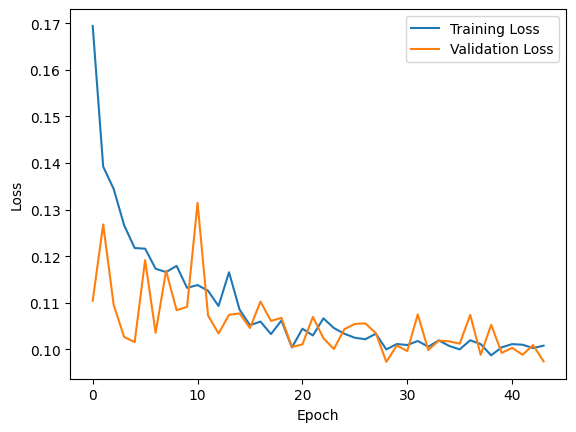

In [8]:
file_path = r'F:\junwei\Transformer_without_sym\all_trails\trial_47.pkl'
#file_path = r'F:\junwei\final_tranformer\best_model_C_R(10HZ-800)\trial_17(10HZ-800,800VOCAB).pkl'
output_dim = 2
device = torch.device('cuda')
loader = BestModelLoader(file_path, output_dim, device)
model, best_train_losses, best_valid_losses = loader.load_best_model()
model.eval()
loader.plot_loss(best_train_losses, best_valid_losses)
preds, targets = loader.test_model(model, test_loader)
R_pre = denormalize_data(preds[:,1],min_resistance, max_resistance)
C_pre = denormalize_data(preds[:,0],min_compliance, max_compliance)
R_true = denormalize_data(targets[:,1],min_resistance, max_resistance)
C_true = denormalize_data(targets[:,0],min_compliance, max_compliance)

In [9]:
evaluator_c = Evaluator(C_true, C_pre)
evaluator_r = Evaluator(R_true, R_pre)

mse1, mae1, nmse1, mape1,r2_1 = evaluator_c.evaluate()

mse2, mae2, nmse2, mape2,r2_2 = evaluator_r.evaluate()

evl = {'Metric': ['MSE','MAE', 'NMSE', 'MAPE'],
        'C': [mse1,mae1, nmse1, mape1],
        'R': [mse2,mae2, nmse2, mape2]
        }

results_df = pd.DataFrame(evl)

results_df.set_index('Metric', inplace=True)

print(results_df)


                 C          R
Metric                       
MSE     158.191513  29.305037
MAE       8.900311   3.188945
NMSE      1.089532   1.014973
MAPE     18.095383  20.403424


In [6]:
with open(loader.path, 'rb') as f:
    _, best_params, _, _ = pickle.load(f)

print("Best parameters:")
for key, value in best_params.items():
    print(f"    {key}: {value}")

Best parameters:
    nhead: 1
    weight_decay: 1.9349297169022876e-05
    num_layers: 4
    dropout: 0.4930032190921708
    lr: 0.0006880778255204007
    num_hidden_layers: 2
    hidden_dim_0: 128
    hidden_dim_1: 32
    d_model: 3
    hidden_layers: [128, 32]


In [10]:
import numpy as np
import matplotlib.pyplot as plt

class BlandAltman2:
    def __init__(self, output_data_unscaled, pre_data_unscaled):
        self.output_data_unscaled = output_data_unscaled
        self.pre_data_unscaled = pre_data_unscaled

    def plot(self, x_label, start, xlim_range,start_y,ylim_range):
        # Convert the values to numpy arrays
        output_data = np.asarray(self.output_data_unscaled)
        pre_data = np.asarray(self.pre_data_unscaled)

        # Calculate the difference and mean
        diff = output_data - pre_data
        mean = (output_data + pre_data) / 2

        # Calculate the percentage difference between predictions and targets
        percentage_diff = (diff / mean) * 100

        # Calculate the mean and standard deviation of the percentage difference
        mean_diff = np.mean(percentage_diff)
        std_diff = np.std(percentage_diff)

        overestimate_indices = []
        underestimate_indices = []
        # Find indices of outliers
        outlier_indices = []

        for i, percentage_error in enumerate(percentage_diff):
            if percentage_error > 20:  # overestimate
                outlier_indices.append(i)
                overestimate_indices.append(i)
            elif percentage_error < -20:  # underestimate
                outlier_indices.append(i)
                underestimate_indices.append(i)

        # Plot the Bland-Altman plot with percentage difference
        fig, ax = plt.subplots(figsize=(8, 5.5))
        for i in range(len(percentage_diff)):
            if i in outlier_indices:
                ax.scatter(output_data[i], percentage_diff[i], color='red', s=15)
            else:
                ax.scatter(output_data[i], percentage_diff[i], color='blue', s=15)
        ax.axhline(mean_diff, color='gray', linestyle='--',lw = 2)
        upper_limit = mean_diff + 1.96 * std_diff
        lower_limit = mean_diff - 1.96 * std_diff
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(20, color='green', linestyle='-',lw = 2.5)
        ax.axhline(-20, color='green', linestyle='-',lw = 2.5)
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('Percentage Difference between Predictions and Targets', fontsize=11)
        #ax.set_title('Bland-Altman Plot', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(start, xlim_range)
        ax.set_ylim(start_y, ylim_range)
        #yticks = np.arange(start_y, ylim_range + 1, 10)  
        #plt.yticks(yticks)
        ax.set_yticks([-60,-50,-40,-30,-20,-10, 0, 10,20,30,40,50,60])
        plt.show()
        print("The Y-coordinate for the upper gray line is: ", upper_limit)
        print("The Y-coordinate for the lower gray line is: ", lower_limit)
        print(f"Mean difference line Y-value: {mean_diff}")
        # Print indices of outliers
        #print("Indices of outliers: ", outlier_indices)
        #print("Indices of overestimations: ", overestimate_indices)
        #print("Indices of underestimations: ", underestimate_indices)
        return outlier_indices, overestimate_indices, underestimate_indices


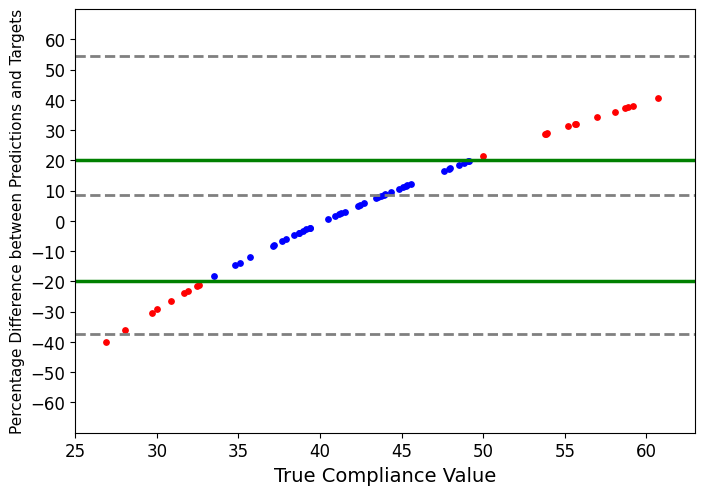

The Y-coordinate for the upper gray line is:  54.585815315246585
The Y-coordinate for the lower gray line is:  -37.46013439178467
Mean difference line Y-value: 8.562840461730957


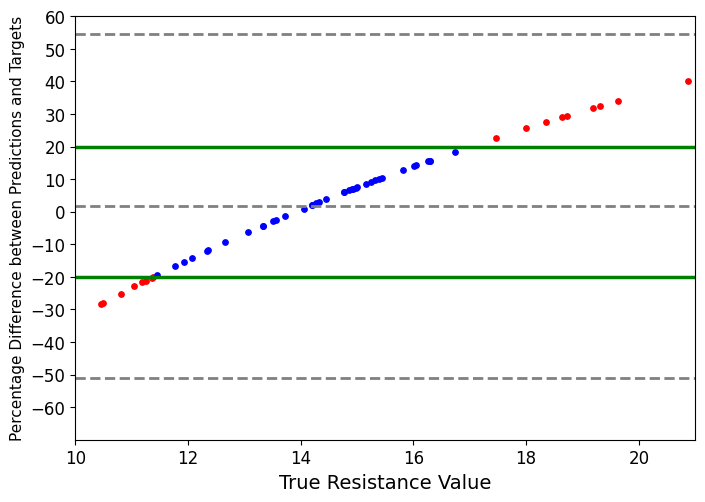

The Y-coordinate for the upper gray line is:  54.68023510456085
The Y-coordinate for the lower gray line is:  -51.11414142131805
Mean difference line Y-value: 1.783046841621399


In [11]:
bland_C = BlandAltman2(C_true, C_pre)
bland_R = BlandAltman2(R_true, R_pre)

outlier_indices_C = bland_C.plot('True Compliance Value',25,63,-70,70)
outlier_indices_R = bland_R.plot('True Resistance Value',10,21,-70,50) 

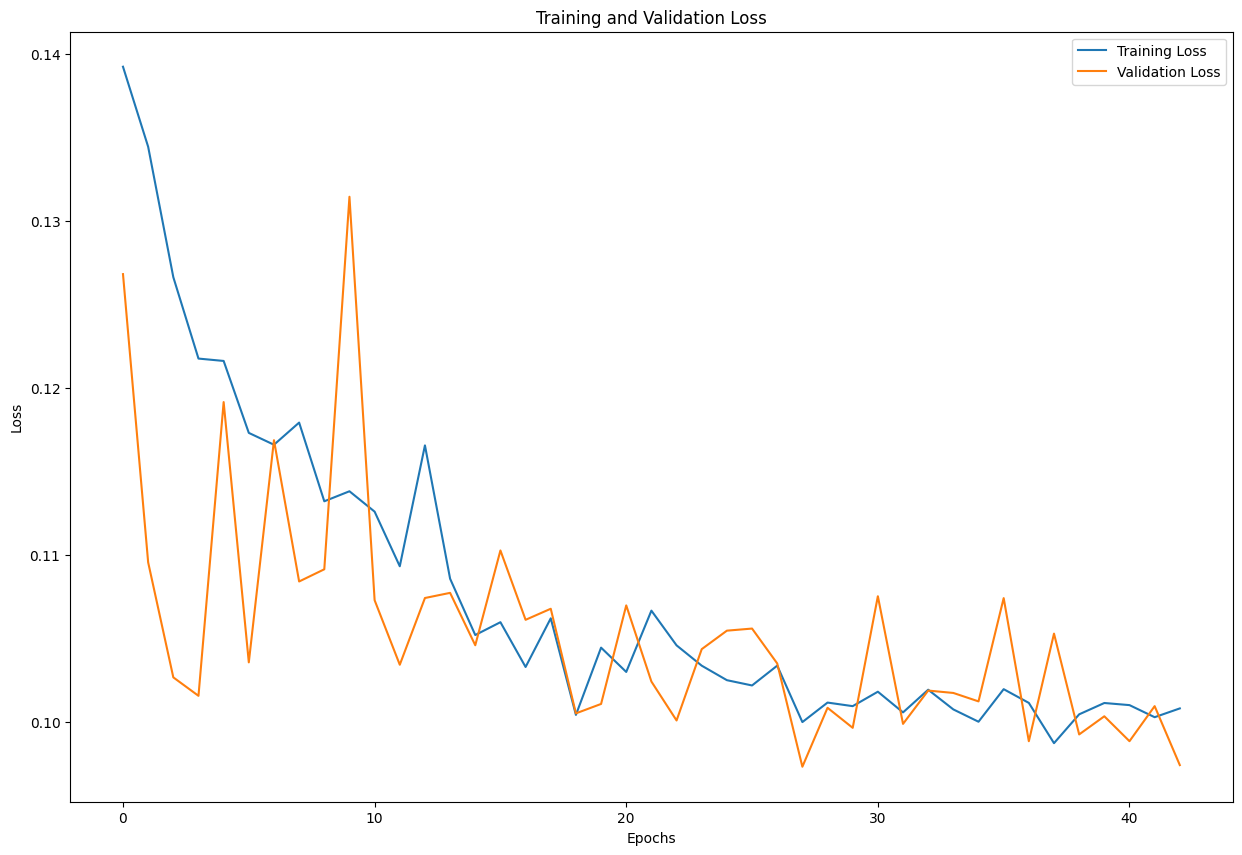

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(best_train_losses[1:], label='Training Loss')
plt.plot(best_valid_losses[1:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
#index1 = 296
#plt.figure()
#plt.plot(flow[index1])
#plt.xlabel('Time')
#plt.ylabel('Flow')
#plt.title('Flow - Sample {}'.format(index1))
#plt.show()

# Plot for pressure
#plt.figure()
#plt.plot(pressure[index1])
#plt.xlabel('Time')
#plt.ylabel('Pressure')
#plt.title('Pressure - Sample {}'.format(index1))
#plt.show()

# Plot for volume
##plt.figure()
#plt.plot(volume[index1])
#plt.xlabel('Time')
#plt.ylabel('Volume')
#plt.title('Volume - Sample {}'.format(index1))
#plt.show()

In [12]:
#plt.scatter(C_true, C_pre)

# Add labels and title
##plt.xlabel('C_true')
#plt.ylabel('C_pre')
#plt.title('C_true vs C_pre')

# Display the plot
#plt.show()

In [13]:
#sequence_tokenizer = WordPiece(vocab_size=2000,max_seq_len=60)
#sequence_tokenizer.train_tokenizer(data)
#directory = r'F:\junwei\final_tranformer\transformer_C _R\wordpiece'

#file_path = os.path.join(directory, 'sequence_tokenizer.pkl')

#with open(file_path, 'wb') as f:
#   pickle.dump(sequence_tokenizer, f)

In [14]:
#train_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\train_data.pickle')
#test_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\test_data.pickle')
#val_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\val_data.pickle')

In [15]:
import numpy as np

def count_lengths(data):
    lengths_dict = {
        '70-80': 0,
        '80-90': 0,
        '90-100': 0,
        '100-110': 0,
        '110-120': 0,
        '120-130': 0,
        '130-140': 0,
        '140-150': 0,
        '150-160': 0,
        '160-170': 0,
        '170-180': 0,
        '180-190': 0,
        '190-200': 0,
        '200-210': 0,
        '210-220': 0,
        '220-230': 0,
        '230-240': 0,
        '250-260': 0
    }

    for sentence in data:
        # Remove padding
        sentence = sentence[sentence != 0]
        
        # Count length
        length = len(sentence)

        # Classify length
        if 70 <= length < 80:
            lengths_dict['70-80'] += 1
        elif 80 <= length < 90:
            lengths_dict['80-90'] += 1
        elif 90 <= length < 100:
            lengths_dict['90-100'] += 1
        elif 100 <= length < 110:
            lengths_dict['100-110'] += 1
        elif 110 <= length < 120:
            lengths_dict['110-120'] += 1
        elif 120 <= length < 130:
            lengths_dict['120-130'] += 1
        elif 130 <= length < 140:
            lengths_dict['130-140'] += 1
        elif 140 <= length < 150:
            lengths_dict['140-150'] += 1
        elif 150 <= length < 160:
            lengths_dict['150-160'] += 1
        elif 160 <= length < 170:
            lengths_dict['160-170'] += 1
        elif 170 <= length < 180:
            lengths_dict['170-180'] += 1
        elif 180 <= length < 190:
            lengths_dict['180-190'] += 1
        elif 190 <= length < 200:
            lengths_dict['190-200'] += 1
        elif 200 <= length < 210:
            lengths_dict['200-210'] += 1
        elif 210 <= length < 220:
            lengths_dict['210-220'] += 1
        elif 220 <= length < 230:
            lengths_dict['220-230'] += 1
        elif 230 <= length < 240:
            lengths_dict['230-240'] += 1
        elif 240 <= length < 250:
            lengths_dict['240-250'] += 1

    return lengths_dict

# Call the function
lengths_dict = count_lengths(padded_data)

# Print the result
for k, v in lengths_dict.items():
    print(f"Number of samples with length {k}: {v}")


NameError: name 'padded_data' is not defined